In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib
#%matplotlib notebook
from scipy import signal
from tqdm import tqdm
from IPython.display import clear_output

import pandas as pd

import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import Normalize 
import matplotlib.animation as animation
from scipy.interpolate import interpn

mpl_colors = iter(cm.rainbow(np.linspace(0, 1, 400)))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def density_scatter(x, y, bins=50, xlim=None, ylim=None, filename=None):
    fig = plt.figure(figsize=(10, 10))
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    
import matplotlib.animation as animation

In [52]:
def get_image_data(filename, gamma=0.6, debug=False, hide_max=False, logscale=False):
    with open(filename, "rb") as f:
        image_size = np.fromfile(f, dtype=np.int32, count=2)
        extent = np.fromfile(f, dtype=np.float32, count=4)
        image = np.fromfile(f, dtype=np.int32).reshape(image_size).T.astype(np.float)

        if (debug):
            _all = image.shape[0] * image.shape[1]
            _z = image[image == 0].shape[0]
            print(f"{filename}")
            print(f"\tzeros: {_z} ({100 * _z/_all}%)")
            print(f"\tmean & std: {np.mean(image)} +- {np.std(image)}")
            print(f"\ttotal_rays: {np.sum(image)}")

        img = np.zeros_like(image)
        if gamma is not None:
            img[image > 0] = image[image > 0]**gamma        
        if logscale is not None and logscale:
            img[image > 0] = np.log10(image[image > 0])
        if img[img == np.max(img)].shape[0] < 5 and hide_max:
            img[img == np.max(img)] = np.mean(img) # removing center-of-mass pixel with extreame amplification
        return img, extent

def get_lc_data(filename, gamma=0.6, debug=False, hide_max=False, logscale=False):
    with open(filename, "rb") as f:
        lcs_columns = np.fromfile(f, dtype=np.int32, count=1)[0]
        lcs_t_steps = np.fromfile(f, dtype=np.int32, count=1)[0]
        lcs_sources = np.fromfile(f, dtype=np.float32, count=3)
        lcs_eccentricities = np.fromfile(f, dtype=np.float32, count=3)
        lcs_data = np.fromfile(f, dtype=np.float32).reshape((lcs_t_steps, lcs_columns)).astype(np.float)
        labels=['t', 'y1', 'y2']
        lcs = ['ad', 'gs', 'ld', 'pl']
        lcs_el = ['el', 'el_orth']
        sources = []
        eccentricities = []
        for s in np.arange(*lcs_sources).astype(np.float):
            s = ('%.5f' % s).rstrip('0').rstrip('.')
            sources.append(s)
            for l in lcs:
                labels.append("%s_r%s" % (l, s))
            for e in np.arange(*lcs_eccentricities).astype(np.float):
                e = ('%.5f' % e).rstrip('0').rstrip('.')
                for l in lcs_el:
                    labels.append("%s_r%s_e%s" % (l, s, e))                    
        for e in np.arange(*lcs_eccentricities).astype(np.float):
            e = ('%.5f' % e).rstrip('0').rstrip('.')
            eccentricities.append(e)
        df = pd.DataFrame(data=lcs_data.copy(), columns=labels)
        df.attrs['lcs_columns'] = lcs_columns
        df.attrs['lcs_t_steps'] = lcs_t_steps
        
        df.attrs['lcs_sources'] = lcs_sources
        df.attrs['lcs_eccentricities'] = lcs_eccentricities
        df.attrs['models'] = lcs
        df.attrs['models_el'] = lcs_el
        df.attrs['sources'] = sources
        df.attrs['eccentricities'] = eccentricities
        return df

In [3]:
def autoscale_y(ax,margin=0.1):
    """This function rescales the y-axis based on the data that is visible given the current xlim of the axis.
    ax -- a matplotlib axes object
    margin -- the fraction of the total height of the y-data to pad the upper and lower ylims"""

    import numpy as np

    def get_bottom_top(line):
        xd = line.get_xdata()
        yd = line.get_ydata()
        lo,hi = ax.get_xlim()
        y_displayed = yd[((xd>lo) & (xd<hi))]
        h = np.max(y_displayed) - np.min(y_displayed)
        bot = np.min(y_displayed)-margin*h
        top = np.max(y_displayed)+margin*h
        return bot,top

    lines = ax.get_lines()
    bot,top = np.inf, -np.inf

    for line in lines:
        new_bot, new_top = get_bottom_top(line)
        if new_bot < bot: bot = new_bot
        if new_top > top: top = new_top

    ax.set_ylim(bot,top)

In [4]:
def cross_corr(t, y1, y2):
    y1_auto_corr = np.dot(y1, y1) / len(y1)
    y2_auto_corr = np.dot(y2, y2) / len(y1)
    #corr = np.correlate(y1, y2, mode='same')
    #unbiased_sample_size = np.correlate(np.ones(len(y1)), np.ones(len(y1)), mode='same')
    corr = signal.correlate(y1, y2)
    unbiased_sample_size = signal.correlate(np.ones(len(y1)), np.ones(len(y1)))
    corr = corr / unbiased_sample_size / np.sqrt(y1_auto_corr * y2_auto_corr)
    res = corr[(len(corr) // 2) : len(corr)]
    return res, t.to_numpy()[:len(res)]

def acorr_zh(t, sig, avg_substracted=True):
    k = sig
    N = len(sig)
    m = int(N/2)
    if avg_substracted:
        k = sig - np.mean(sig)
    acf = []
    for i in range(0, m, 1):
        kt = np.pad(k, (i, 0), 'constant', constant_values=0)[:len(k)]
        kt2 = np.power(np.pad(k, (int(i/2), 0), 'constant', constant_values=0)[:len(k)], 2)
        acf.append(np.sum(k * kt) / np.sum(kt2))
    acf = np.array(acf)
    lag = np.arange(m) * (t[1] - t[0])
    return lag, acf

In [8]:
if False:
    rays_y = np.loadtxt("./output/test/rays_0.00.dat")
    m = np.logical_and(np.abs(rays_y[:,0]) <= 100, np.abs(rays_y[:,1]) <= 100)
    x = rays_y[:,0][m]
    y = rays_y[:,1][m]
    density_scatter(x, y, bins=[200, 200])

In [9]:
if False:
    filename1 = "output/test1234567890/image_0.00.dat"
    filename2 = "output/test1234567890/image_0.00.dat"

    img1, extent1 = get_image_data(filename1, gamma=1, debug=True)
    img2, extent2 = get_image_data(filename2, gamma=1, debug=True)

    fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
    pos1 = ax1.imshow(img1, interpolation='none', extent=extent1, origin='lower')
    pos2 = ax2.imshow(img2, interpolation='none', extent=extent2, origin='lower')
    ax1.set_title(filename1)
    ax2.set_title(filename2)
    fig.colorbar(pos1, ax=ax1)
    fig.colorbar(pos2, ax=ax2)
    fig.tight_layout()
    plt.show()
if False:
    filename1 = "output/reference/image_0.00.dat"
    filename2 = "output/reference/lc_0.00.dat"

    img1, extent1 = get_image_data(filename1, logscale=True, debug=True)
    lc = get_lc_data(filename2)

    fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
    pos1 = ax1.imshow(img1, interpolation='bessel', extent=extent1, origin='lower')
    ax1.plot(lc['y1'], lc['y2'], color='red')
    pos2 = ax2.plot(lc['t'], lc['a_gs'], '-', color='blue')
    ax2.plot(lc['t'], lc['a_ad'], '-', color='orange')
    ax2.plot(lc['t'], lc['a_pl'], '-', color='green')
    ax2.plot(lc['t'], lc['a_pl'], '-', color='grey')
    ax2.plot(lc['t'], lc['a_el'], '-', color='red', linestyle='dotted')
    #pos2 = ax2.plot(lc['y1'], lc['norm'], '-')
    #pos2 = ax2.plot(lc['y1'], lc['ampl'], '-')
    ax1.set_title(filename1)
    ax2.set_title(filename2)
    fig.colorbar(pos1, ax=ax1)
    fig.tight_layout()
    plt.show()
if False:
    filename1 = "output/reference/image_0.00.dat"
    filename2 = "output/reference/lc_0.00.dat"

    img1, extent1 = get_image_data(filename1, logscale=True, debug=True)
    lc = get_lc_data(filename2)

    fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
    pos1 = ax1.imshow(img1, interpolation='bessel', extent=extent1, origin='lower')
    ax1.plot(lc['y1'], lc['y2'], color='red')
    pos2 = ax2.plot(lc['t'], lc['a_gs'], '-', label='gs')
    ax2.plot(lc['t'], lc['a_ad'], '-', label='ad')
    ax2.plot(lc['t'], lc['a_pl'], '-', label='pl')
    ax2.plot(lc['t'], lc['a_ld'], '-', label='ld')
    ax2.plot(lc['t'], lc['a_el'], '-', linestyle='dotted', label='el')
    ax2.plot(lc['t'], lc['a_el'], '-', linestyle='dashed', label='el ⊥')
    ax2.legend()
    #pos2 = ax2.plot(lc['y1'], lc['norm'], '-')
    #pos2 = ax2.plot(lc['y1'], lc['ampl'], '-')
    ax1.set_title(filename1)
    ax2.set_title(filename2)
    fig.colorbar(pos1, ax=ax1)
    fig.tight_layout()
    plt.show()

In [1]:
if False:
    from scipy import signal
    import matplotlib.colors as mcolors

    fig, ax_corr = plt.subplots(1, 1, figsize=(9, 5))

    lags = None
    lags1 = None


    index = 0
    for e in ['0.7', '0.9']:
        a1 = []
        a2 = []

        a3 = []
        a4 = []
        for t in np.arange(0, 50, 0.1):
            if 10 * t % 10 == 0:
                print(t)

            filename2 = "output/e%s_r0.2/lc_%.2f.dat" % (e, t)
            lc = get_lc_data(filename2)

            tc = lc['t']
            sig1 = lc['a_el'] - np.mean(lc['a_el'])
            sig2 = lc['a_el_orth'] - np.mean(lc['a_el_orth'])

            #corr1, lags = cross_corr(tc, sig1, sig1)
            #corr2, lags = cross_corr(tc, sig2, sig2)
            #a1.append(corr1)
            #a2.append(corr2)

            c1 = signal.correlate(sig1, sig1)
            c2 = signal.correlate(sig2, sig2)
            c1 /= np.max(c1)
            c2 /= np.max(c2)


            lags, c1 = acorr_zh(tc, sig1)
            lags, c2 = acorr_zh(tc, sig2)

            a1.append(c1)
            a2.append(c2)

            #lags = signal.correlation_lags(len(sig1), len(sig1)) * (tc[1] - tc[0])

        step = 1

        ax_corr.errorbar(lags[::step], y=np.mean(a1, axis=0)[::step], yerr=np.std(a1, axis=0)[::step]/np.sqrt(len(a1)), c=colors[index], label='EL $\epsilon = %s$' % e)
        index+=1
        ax_corr.errorbar(lags[::step], y=np.mean(a2, axis=0)[::step], yerr=np.std(a2, axis=0)[::step]/np.sqrt(len(a2)), c=colors[index], label='EL ⊥ $\epsilon = %s$' % e)
        index+=1

    ax_corr.set_title('$R=0.2R_E$, $N=500$')
    ax_corr.set_xlabel('Lag ($R_E$)')
    ax_corr.set_ylabel('ACF')
    ax_corr.set_xlim([0, 5])
    ax_corr.autoscale_view()
    autoscale_y(ax_corr)
    fig.tight_layout()
    plt.show()

In [11]:
directory='s0.4_e0.1-0.9_r0.1-0.7'
iterations = np.arange(0, 100, 0.1)

c0s = {}
c1s = {}
c2s = {}
c3s = {}
c4s = {}
c5s = {}
lags = None

for t in tqdm(iterations):
    t = float(('%.5f' % t).rstrip('0').rstrip('.'))
    filename_lc = f"output/{directory}/lc_%.2f.dat" % (t)
    lc = get_lc_data(filename_lc)
    lc_t = lc['t']
    lc_y1 = lc['y1']
    lc_y2 = lc['y2']
    lags = signal.correlation_lags(len(lc_t), len(lc_t)) * (lc_t[1] - lc_t[0])
    mask = np.logical_and(lags >= 0, lags <= np.max(lc_t)/2)
    lags = lags[mask]
    for r in lc.attrs['sources']:
        if r not in c0s:
            c0s[r] = []
            c1s[r] = []
            c2s[r] = []
            c3s[r] = []
            c4s[r] = {}
            c5s[r] = {}
            
        ad = lc['ad_r%s' % r]
        gs = lc['gs_r%s' % r]
        ld = lc['ld_r%s' % r]
        pl = lc['pl_r%s' % r]
        
        ad1 = ad - np.mean(ad)
        gs1 = gs - np.mean(gs)
        ld1 = ld - np.mean(ld)
        pl1 = pl - np.mean(pl)
        
        c0 = signal.correlate(ad1, ad1)[mask]
        c1 = signal.correlate(gs1, gs1)[mask]
        c2 = signal.correlate(ld1, ld1)[mask]
        c3 = signal.correlate(pl1, pl1)[mask]
        c0 /= np.max(c0)
        c1 /= np.max(c1)
        c2 /= np.max(c2)
        c3 /= np.max(c3)
        
        c0s[r].append(c0)
        c1s[r].append(c1)
        c2s[r].append(c2)
        c3s[r].append(c3)
        
        for e in lc.attrs['eccentricities']:
            if e not in c4s[r]:
                c4s[r][e] = []
                c5s[r][e] = []
                
            el = lc['el_r%s_e%s' % (r, e)]
            el_orth = lc['el_orth_r%s_e%s' % (r, e)]
            
            el1 = el - np.mean(el)
            el_orth1 = el_orth - np.mean(el_orth)
           
            c4 = signal.correlate(el1, el1)[mask]
            c5 = signal.correlate(el_orth1, el_orth1)[mask]
            c4 /= np.max(c4)
            c5 /= np.max(c5)
            
            c4s[r][e].append(c4)
            c5s[r][e].append(c5)

100%|██████████| 1000/1000 [02:42<00:00,  6.14it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


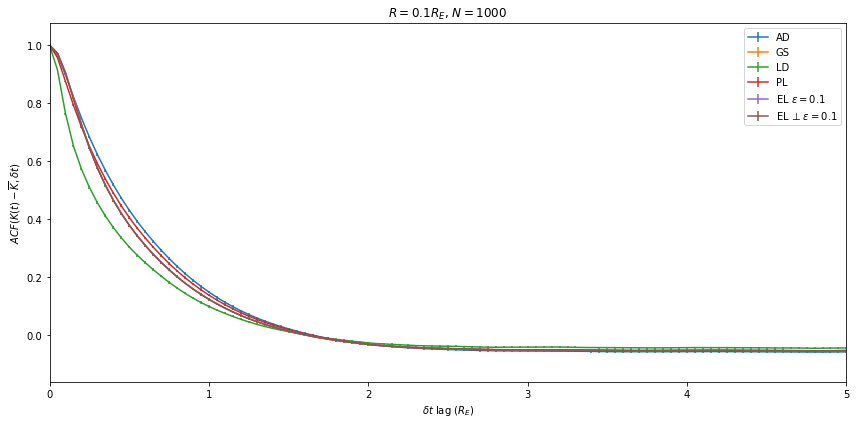

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


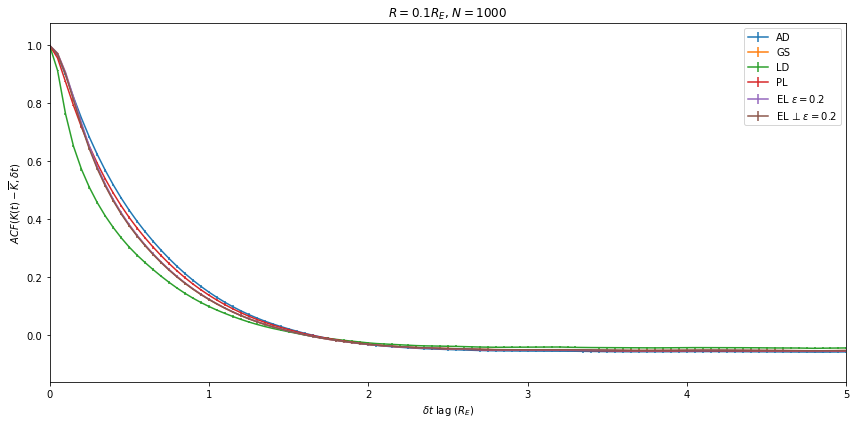

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


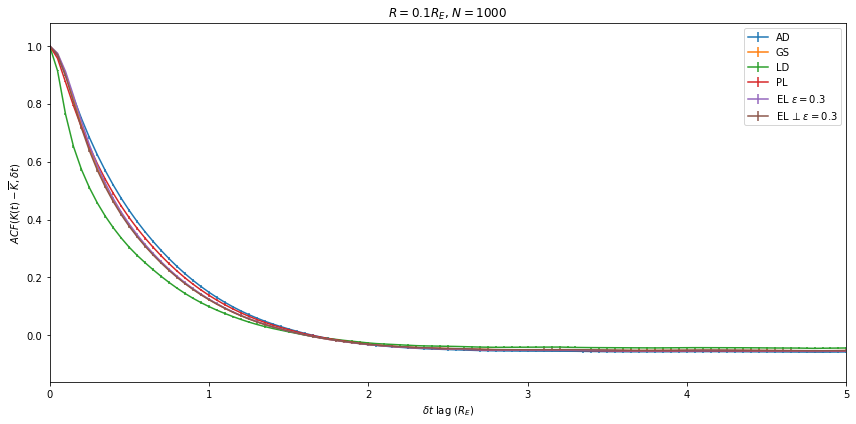

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


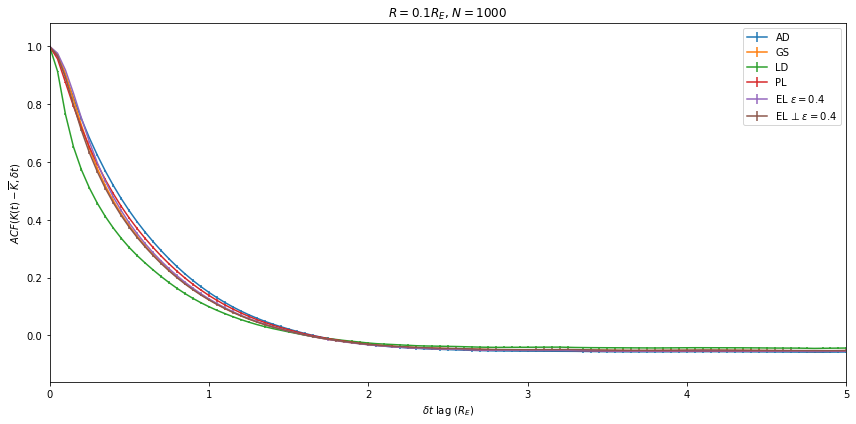

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


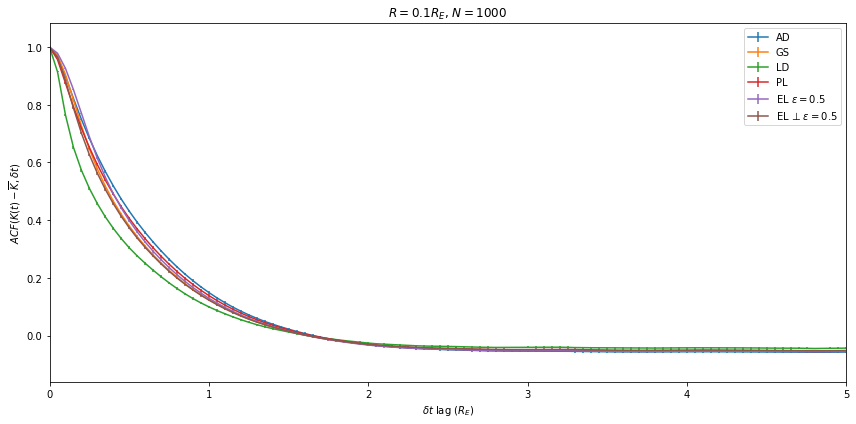

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


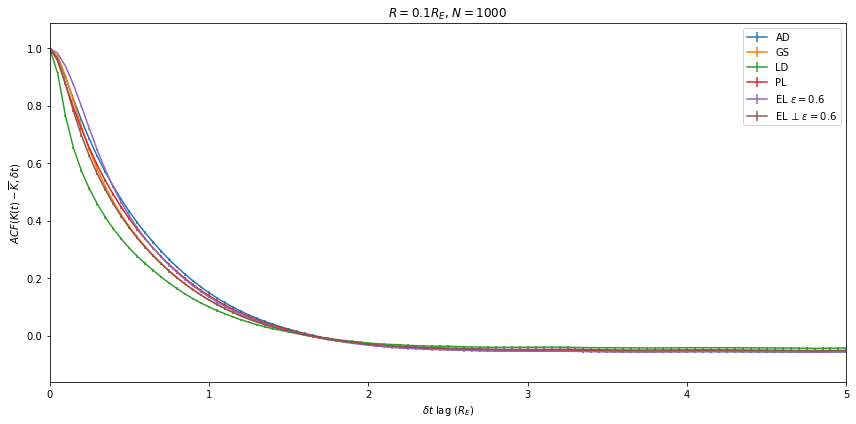

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


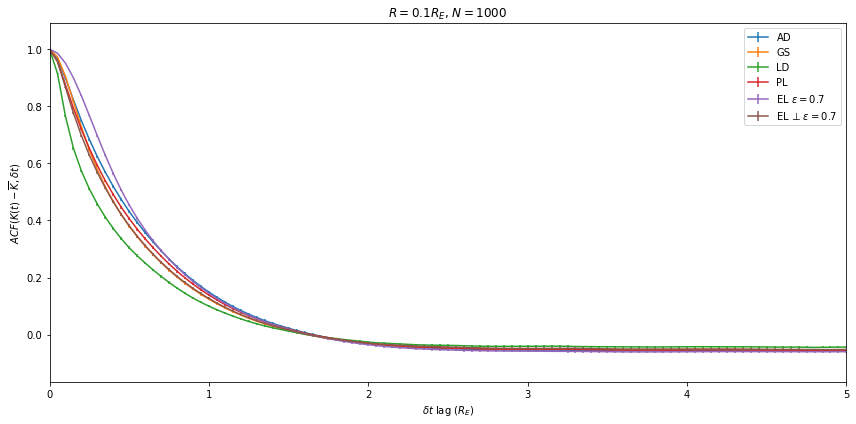

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


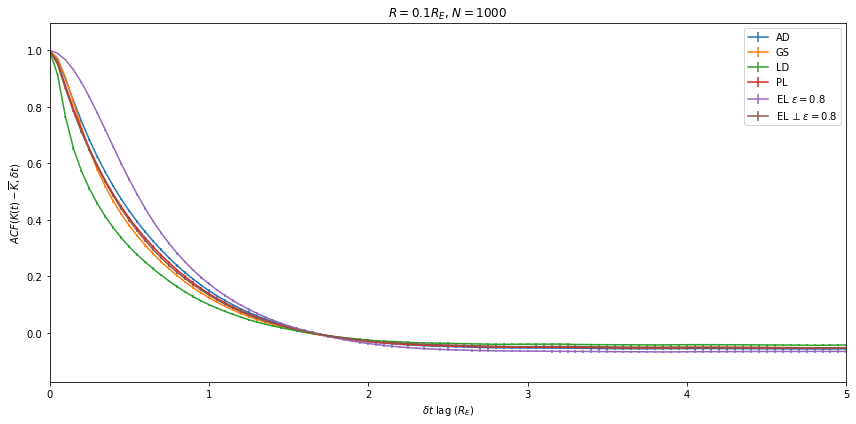

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


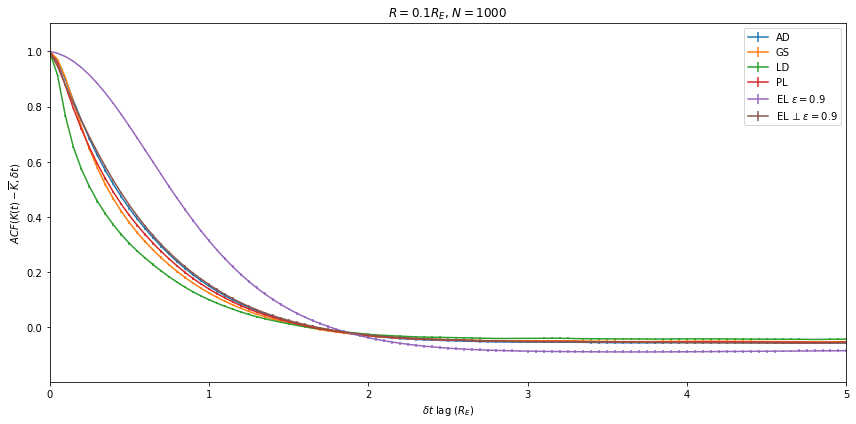

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


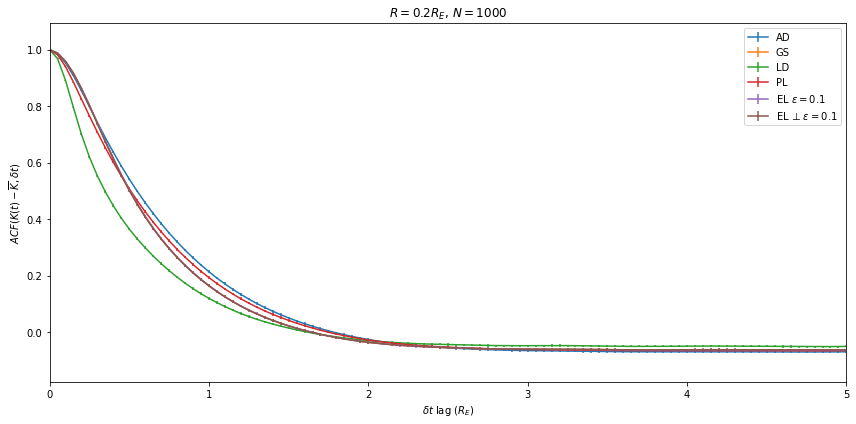

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


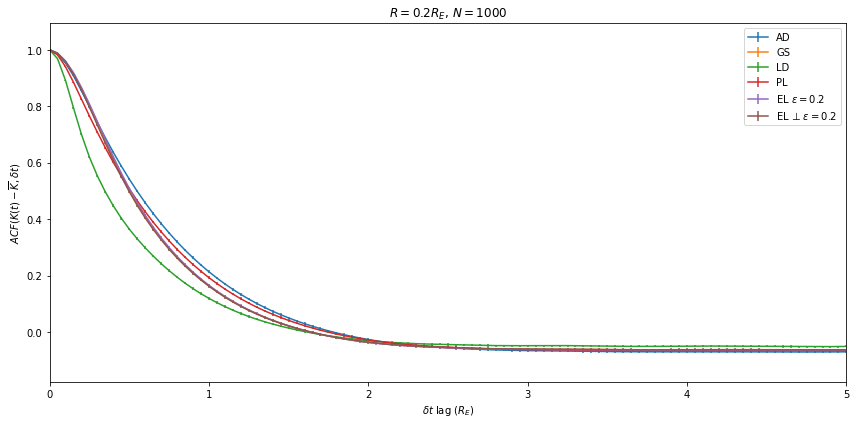

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


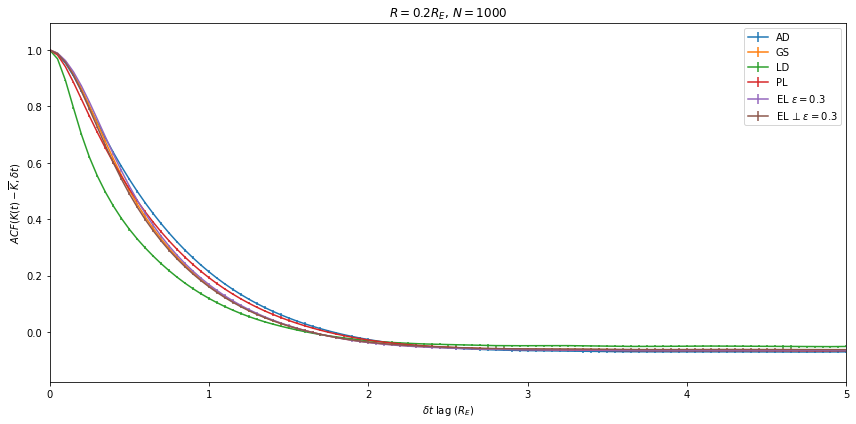

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


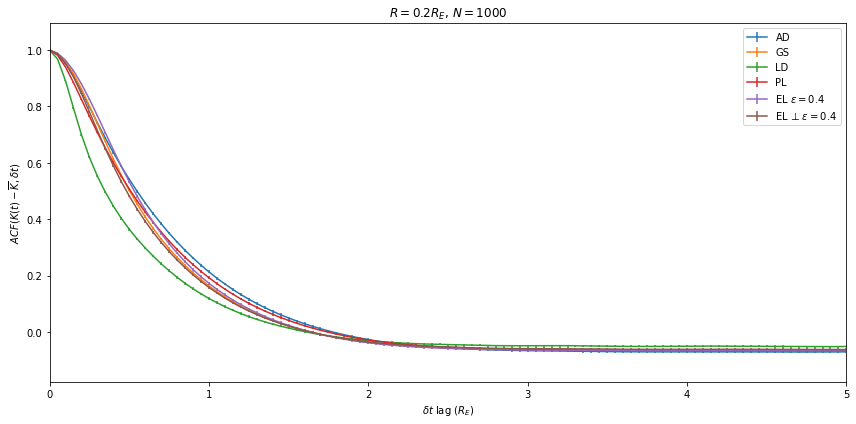

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


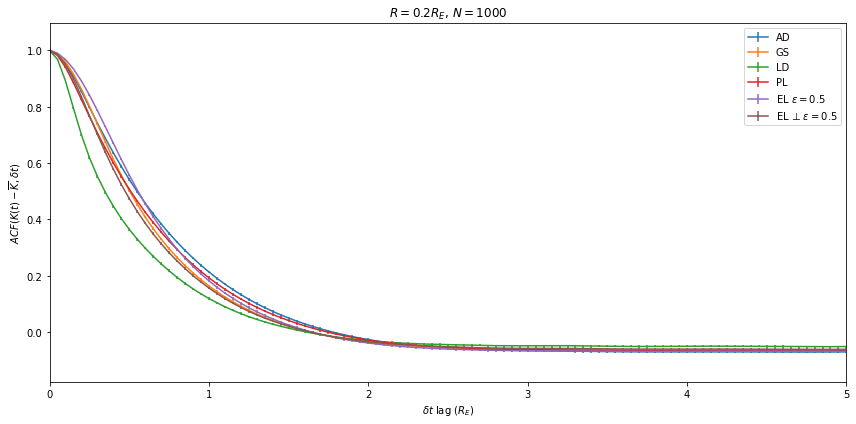

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


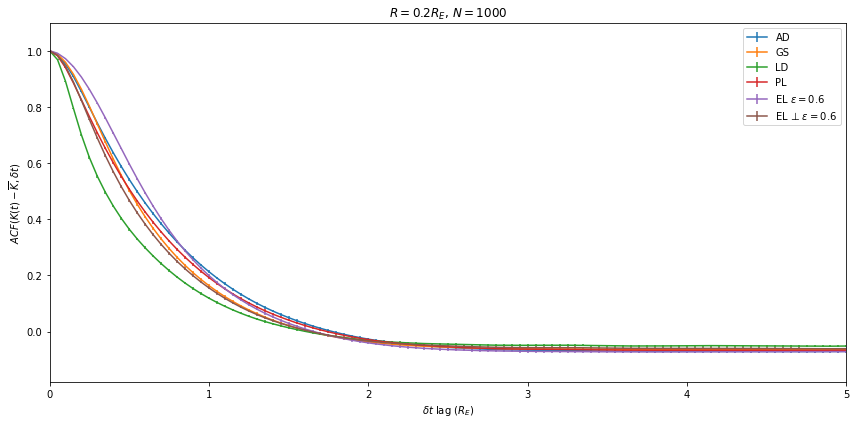

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


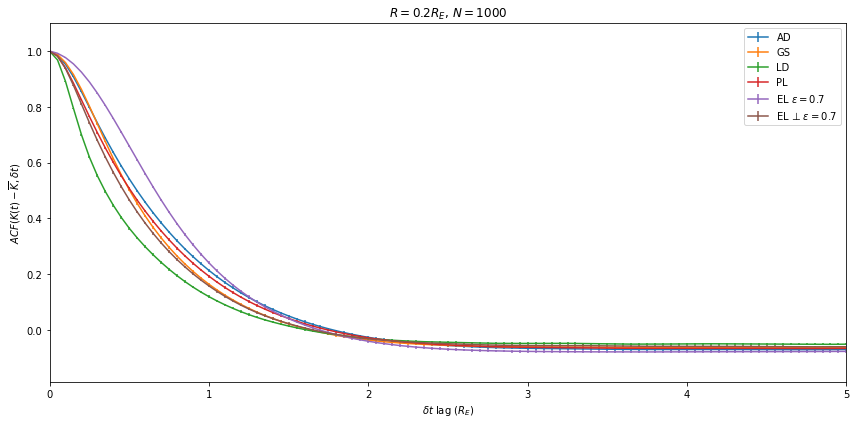

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


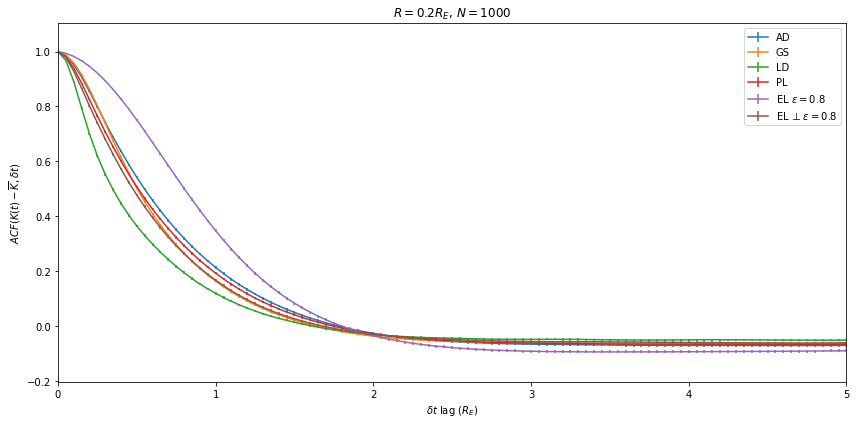

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


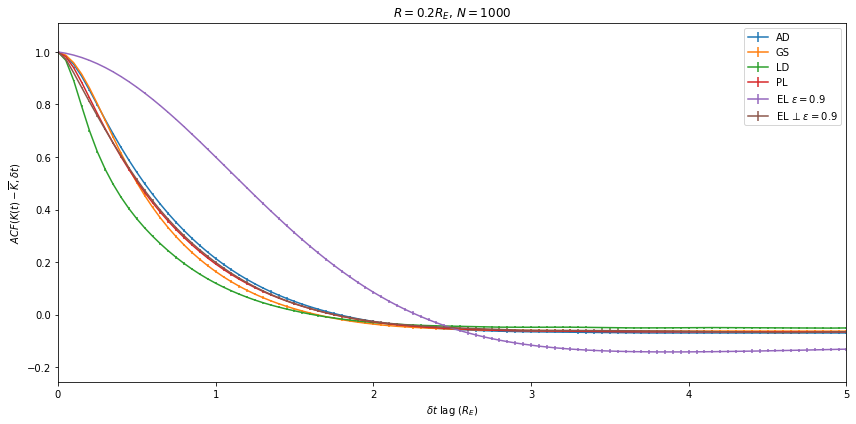

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


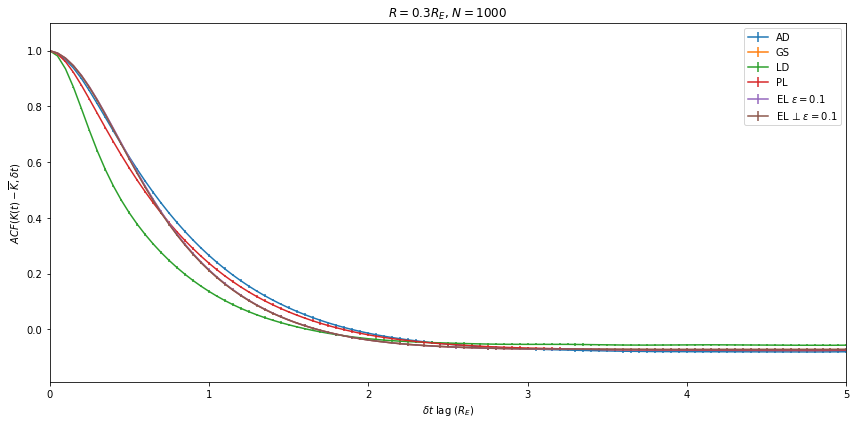

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


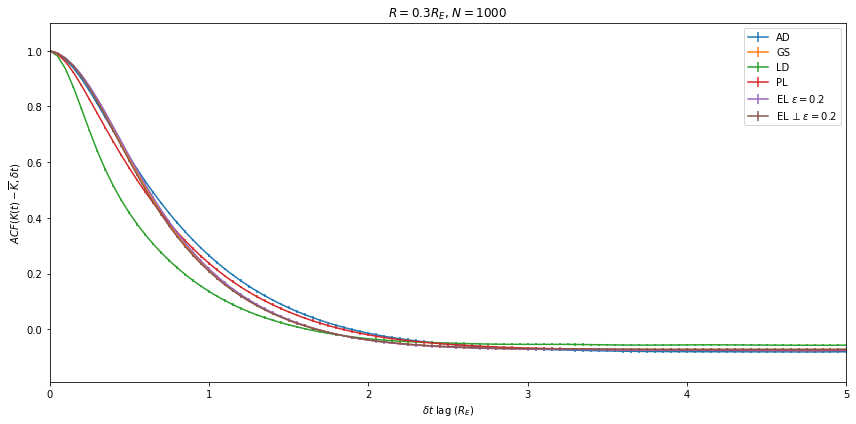

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


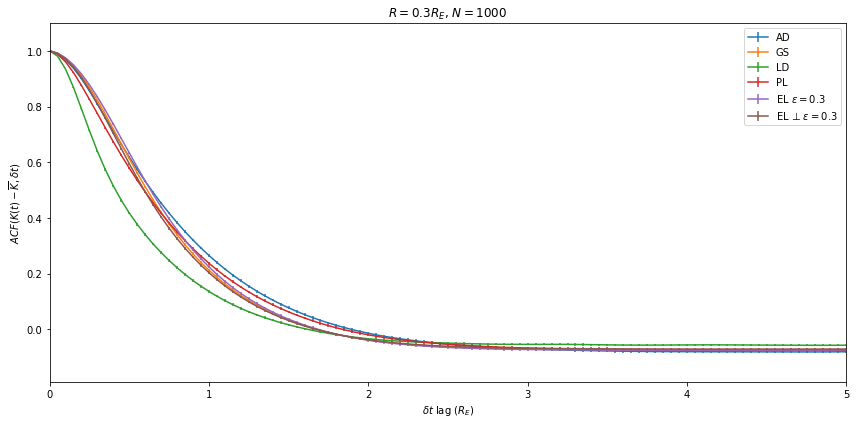

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


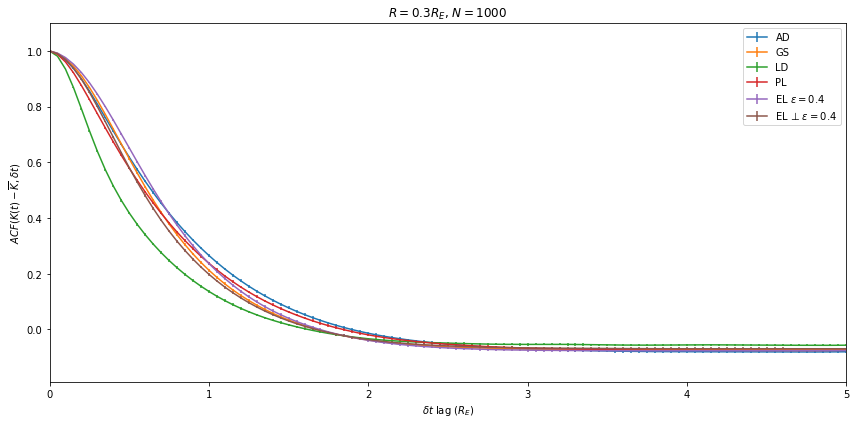

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


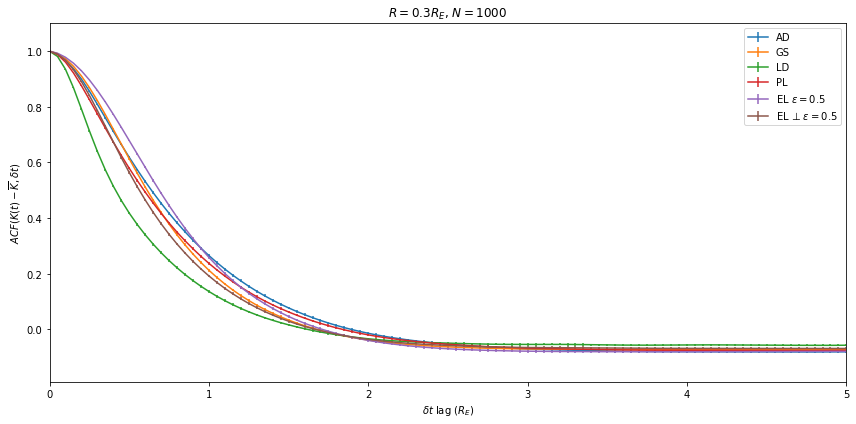

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


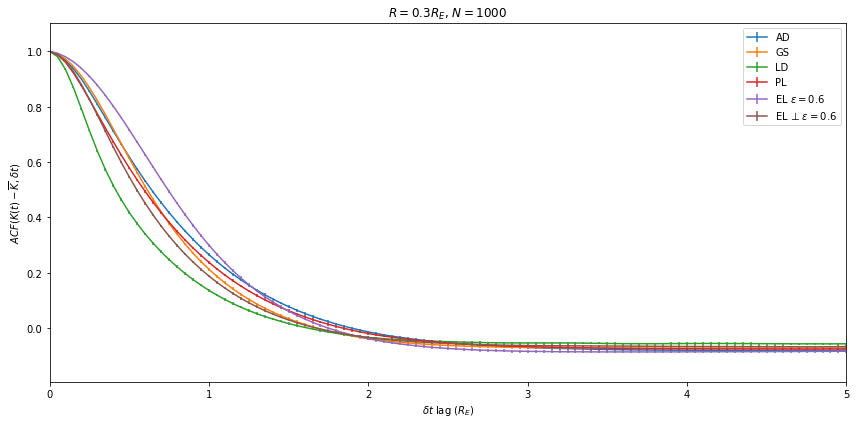

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


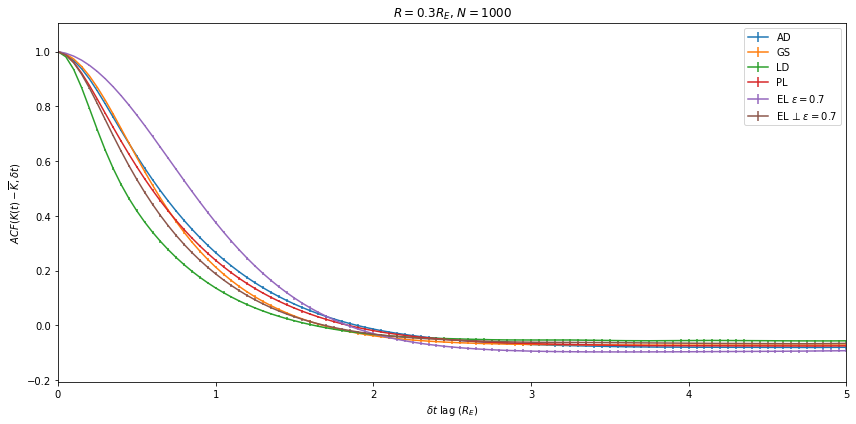

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


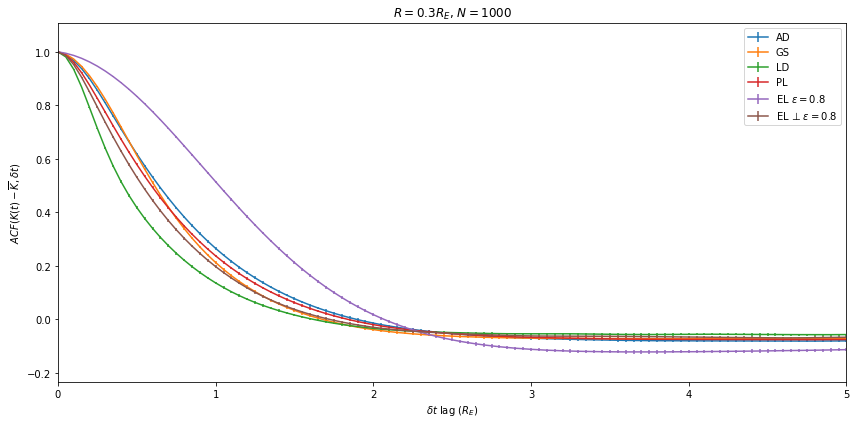

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


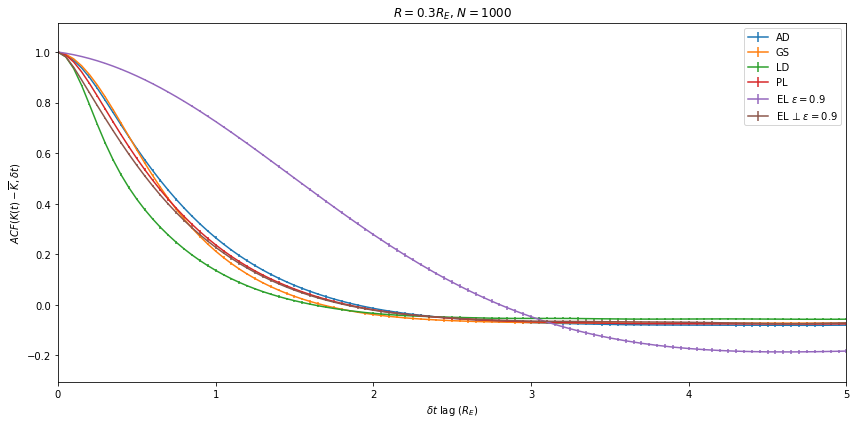

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


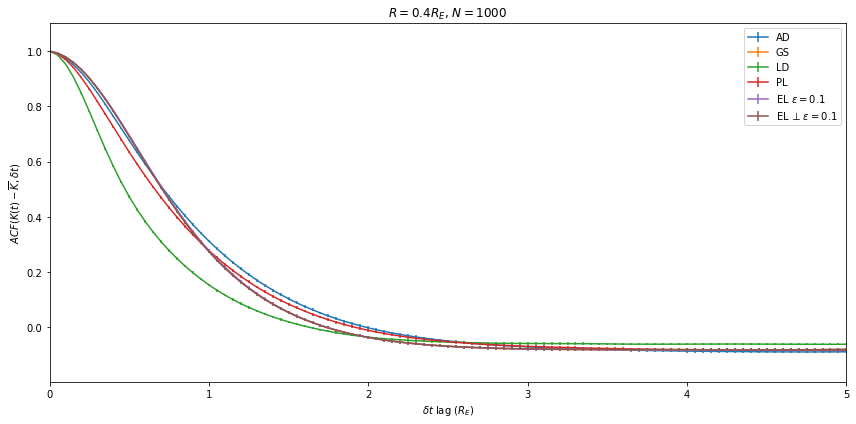

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


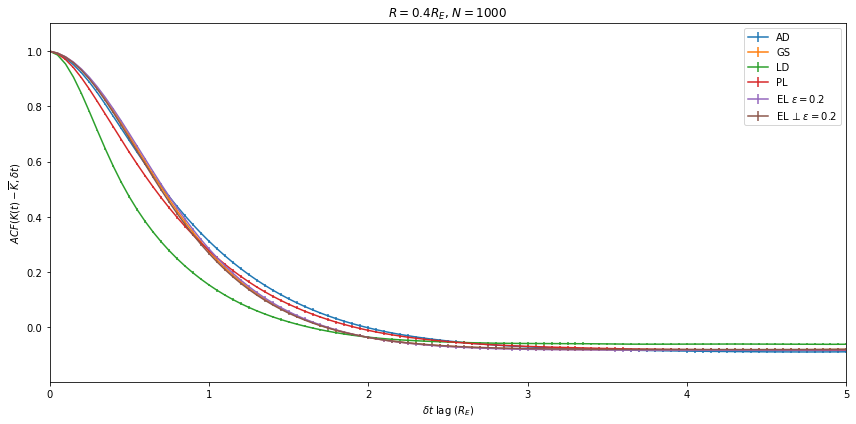

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


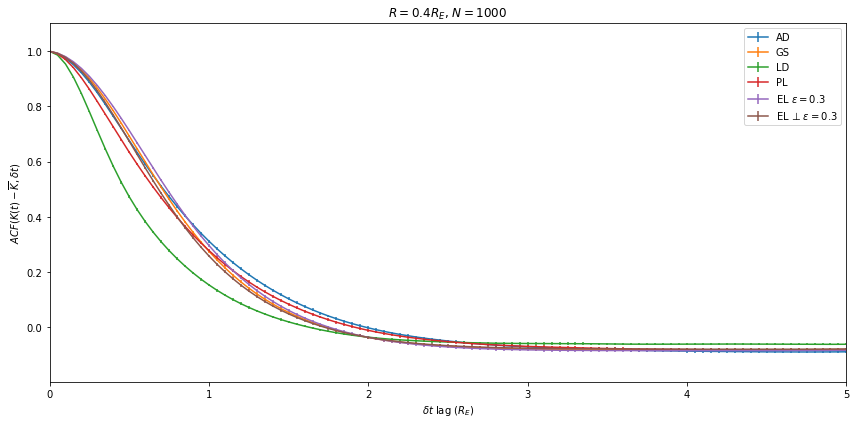

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


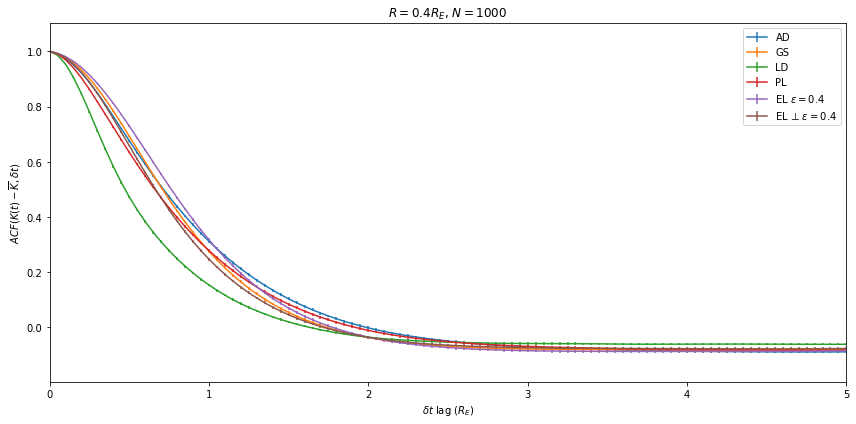

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


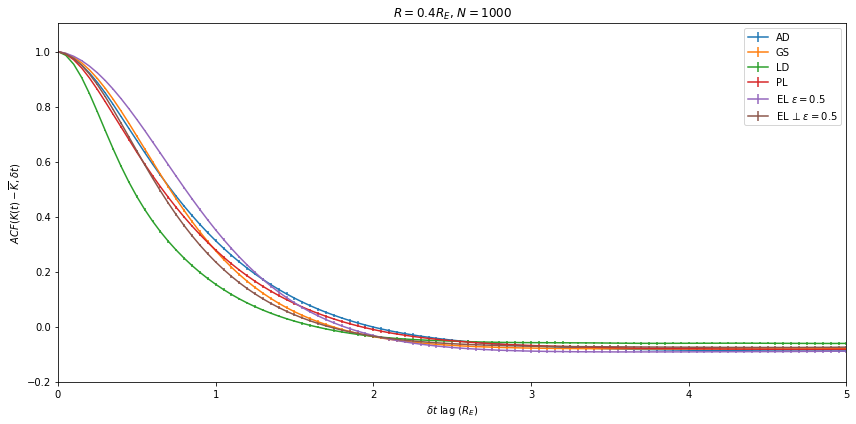

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


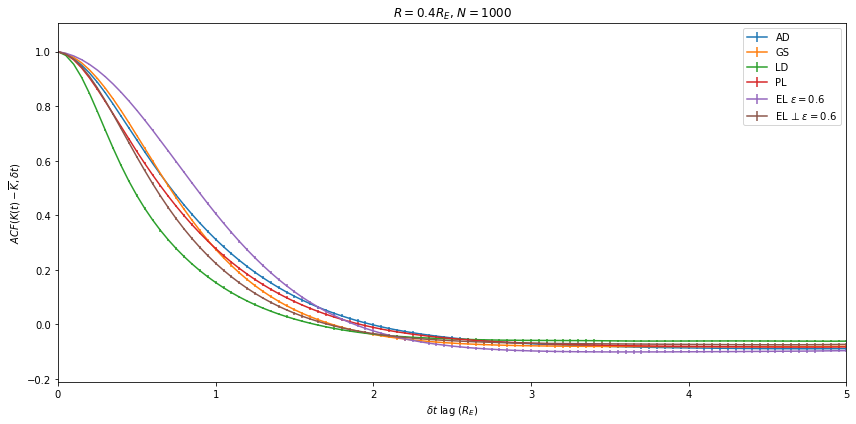

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


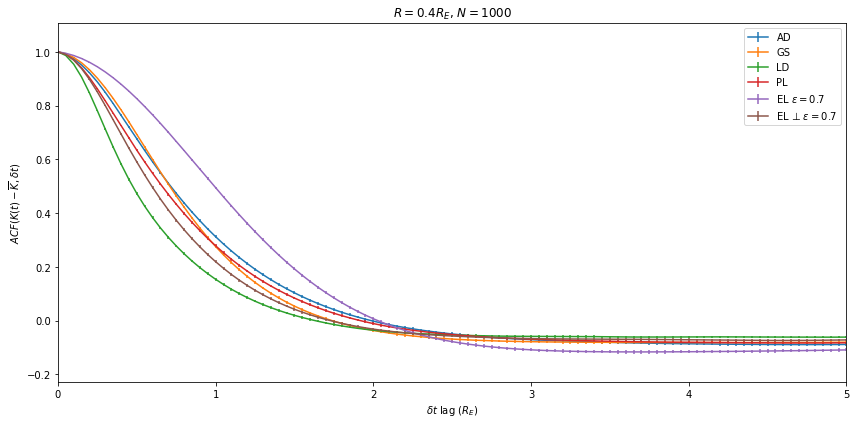

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


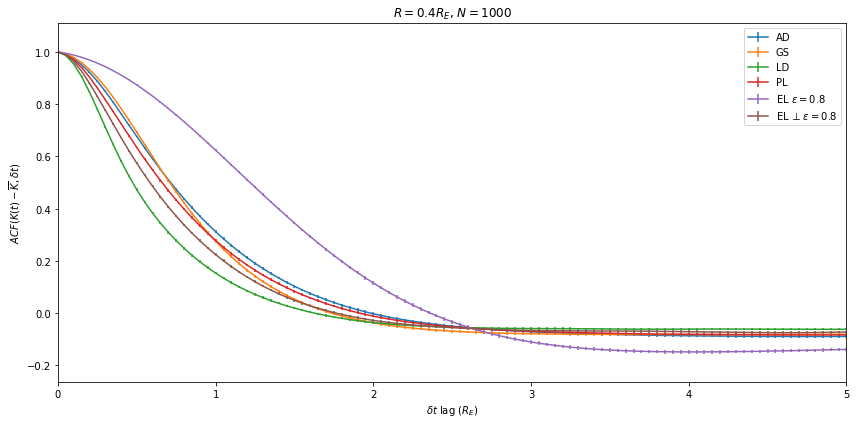

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


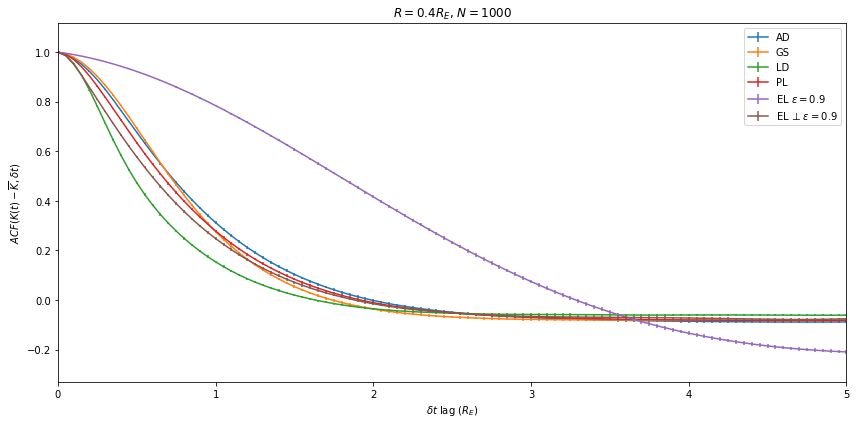

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


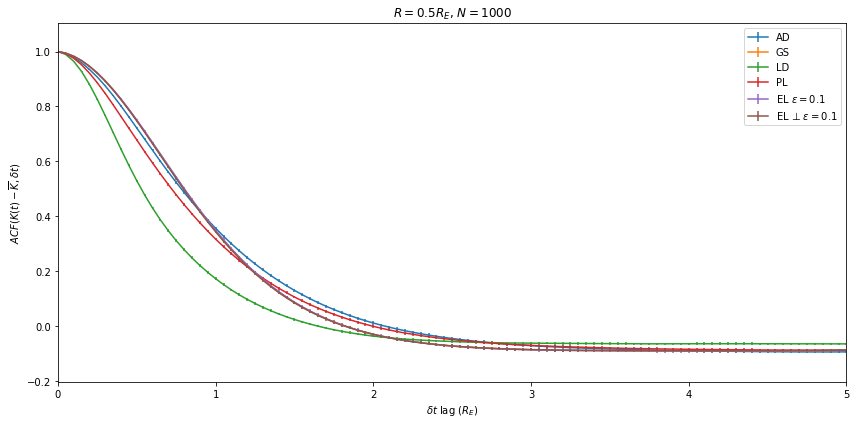

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


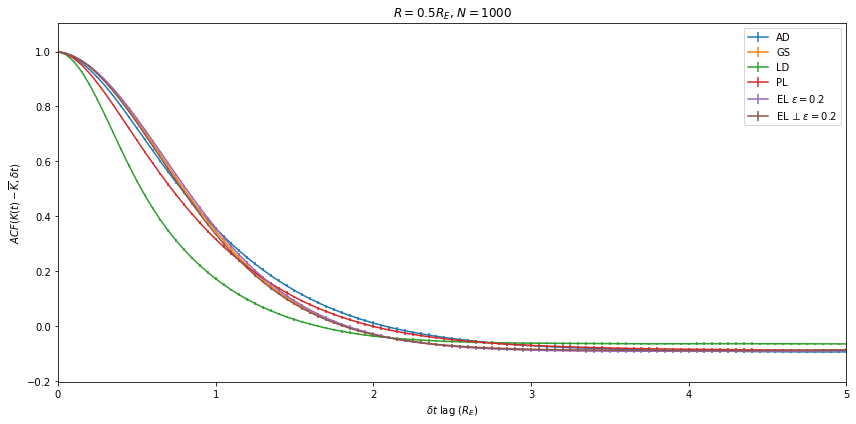

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


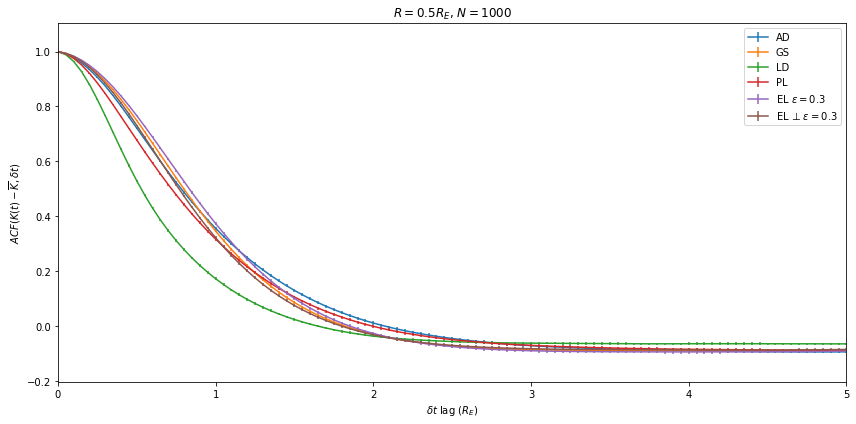

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


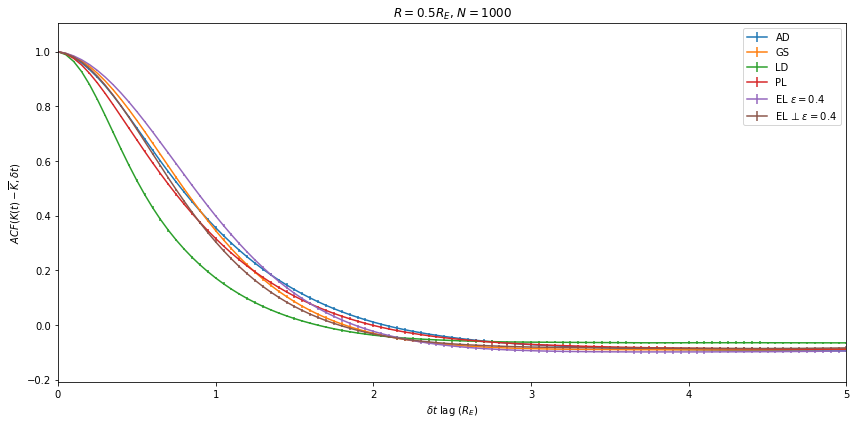

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


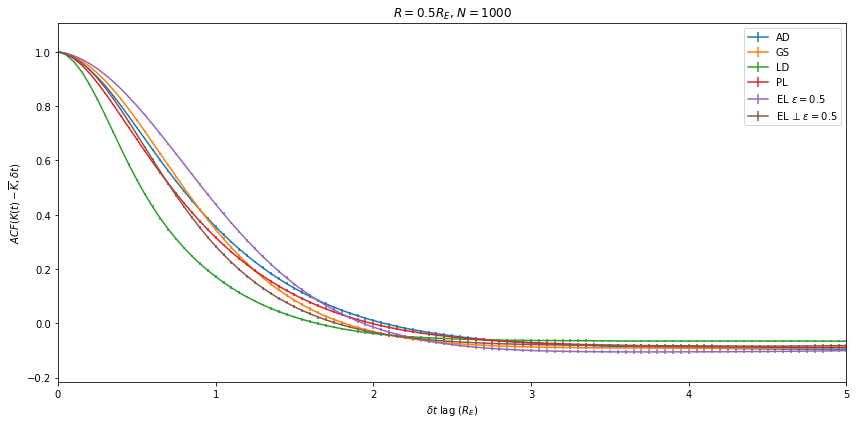

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


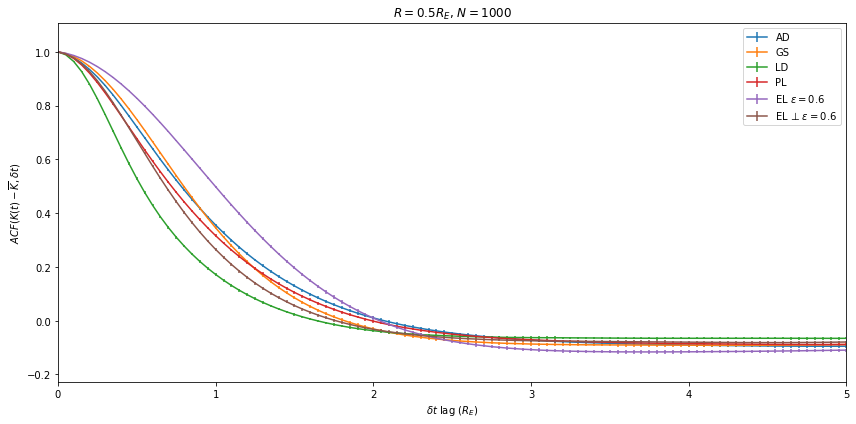

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


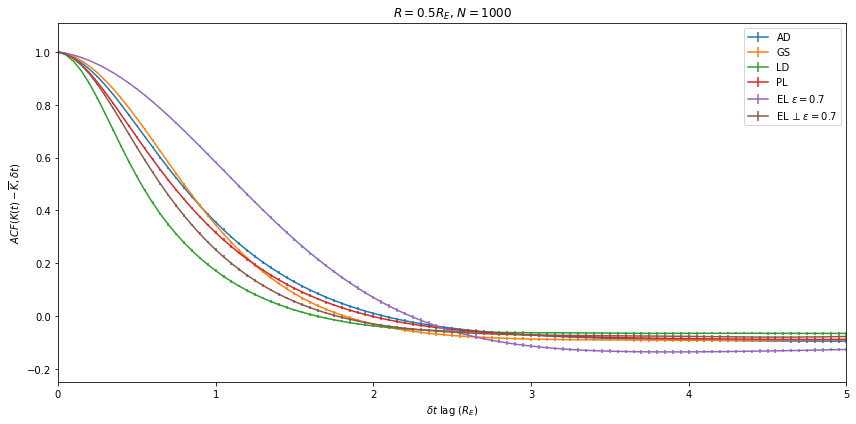

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


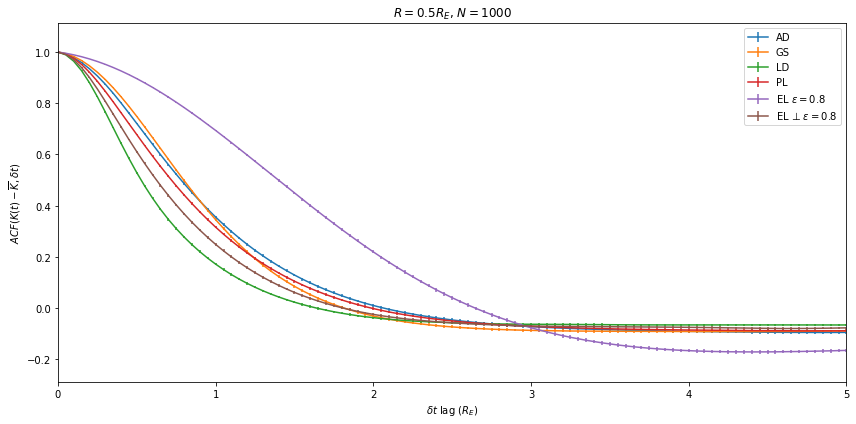

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


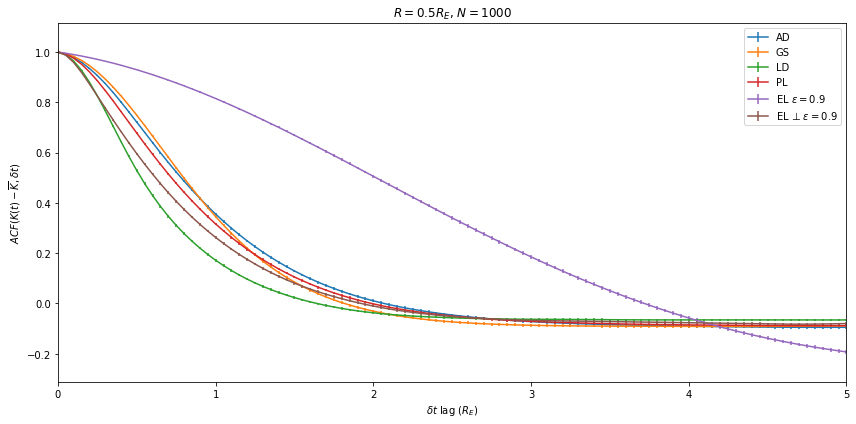

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


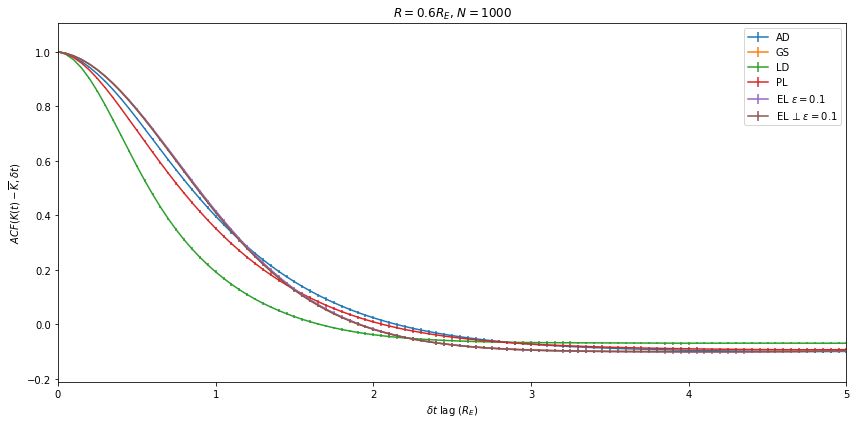

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


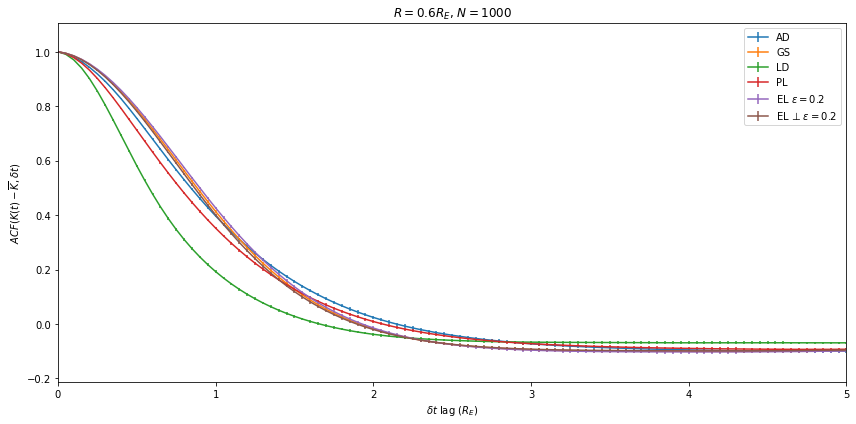

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


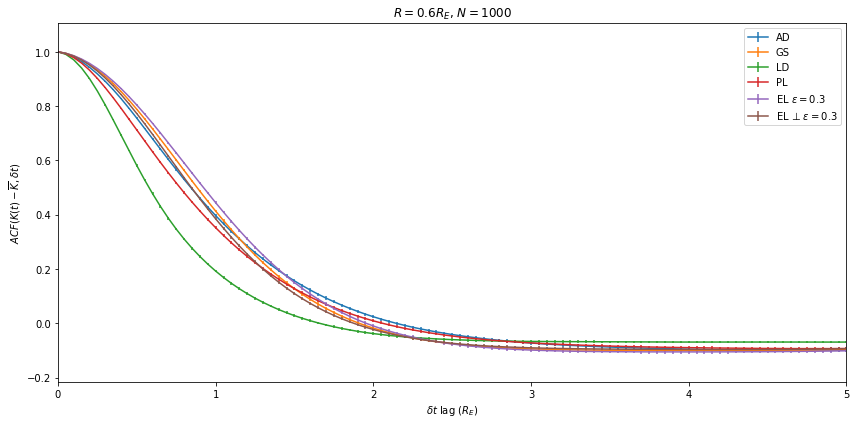

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


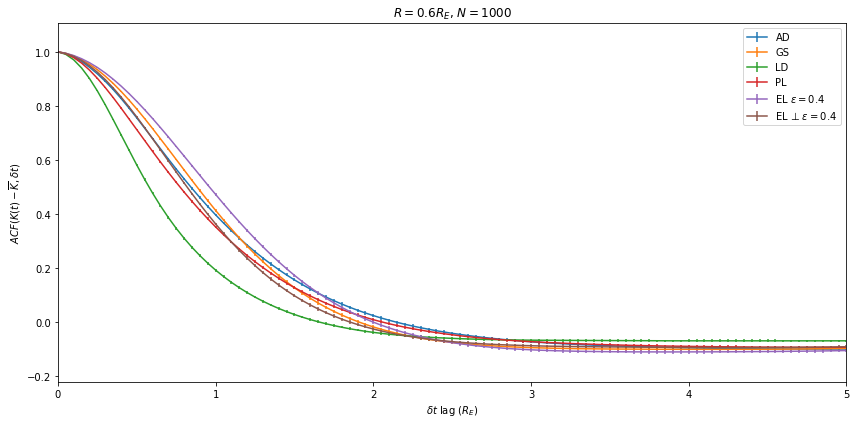

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


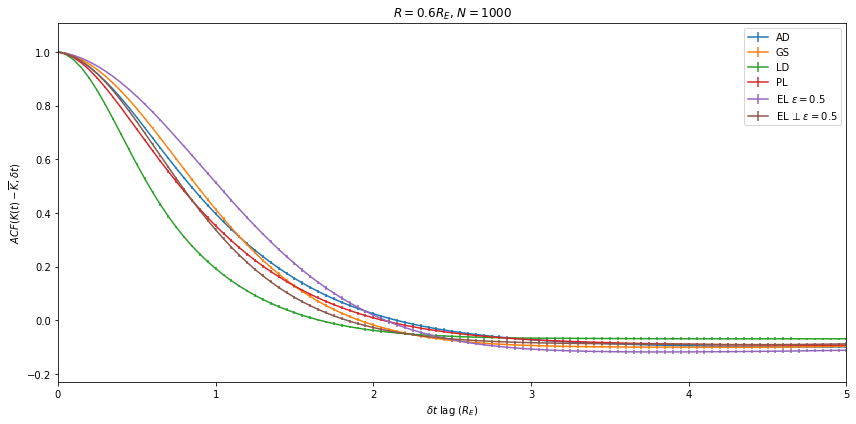

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


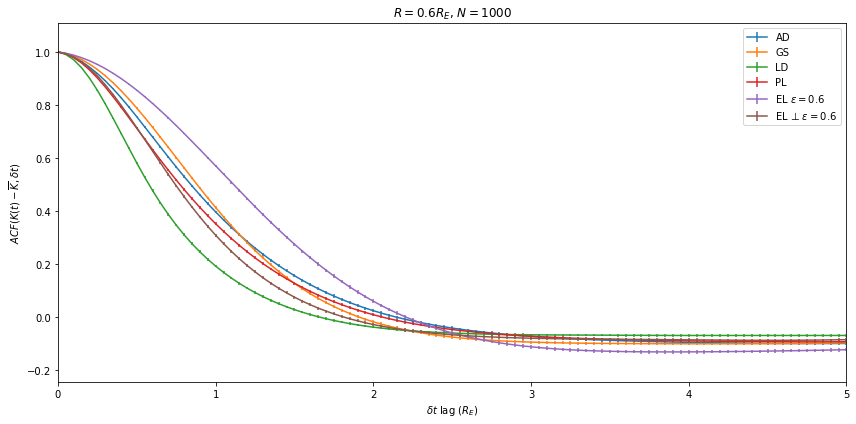

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


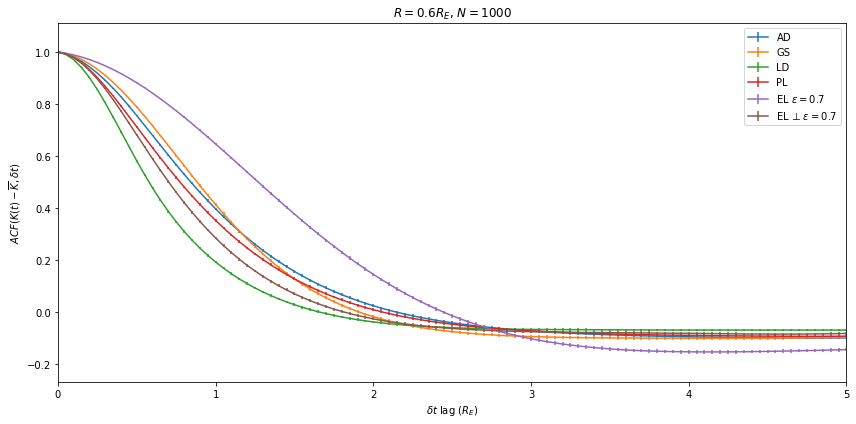

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


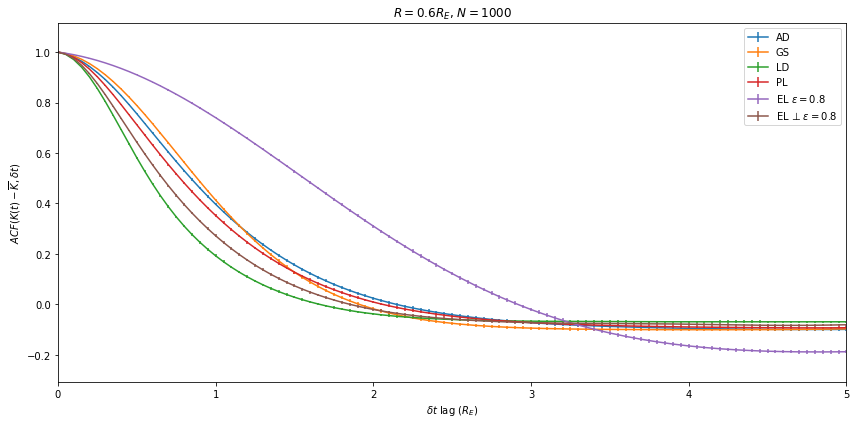

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


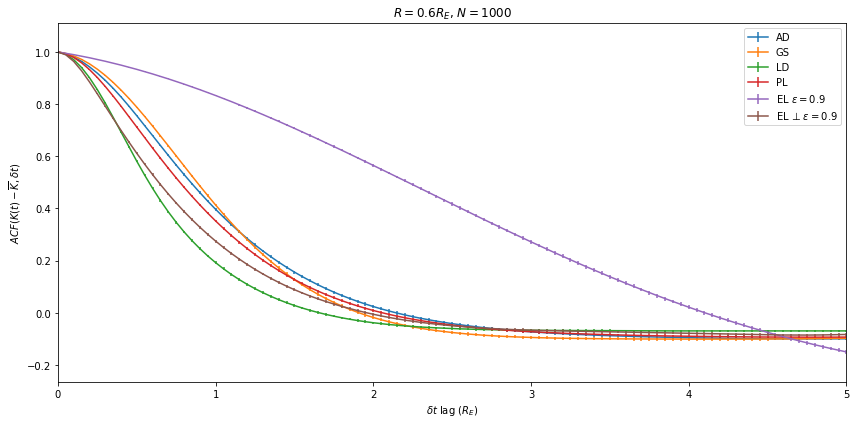

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


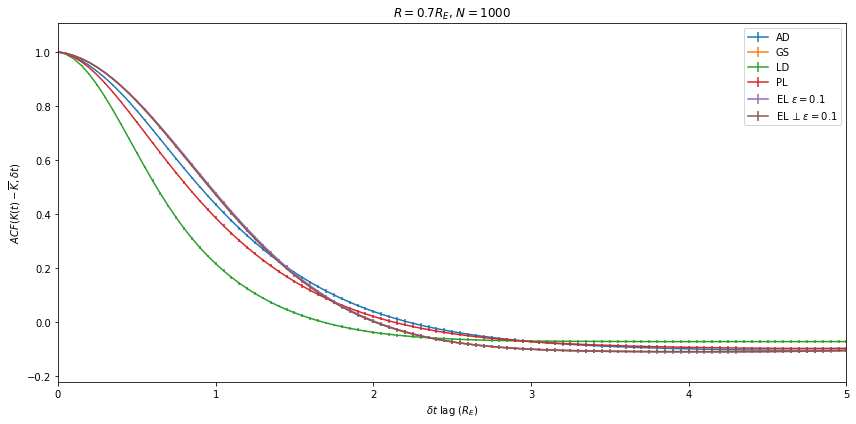

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


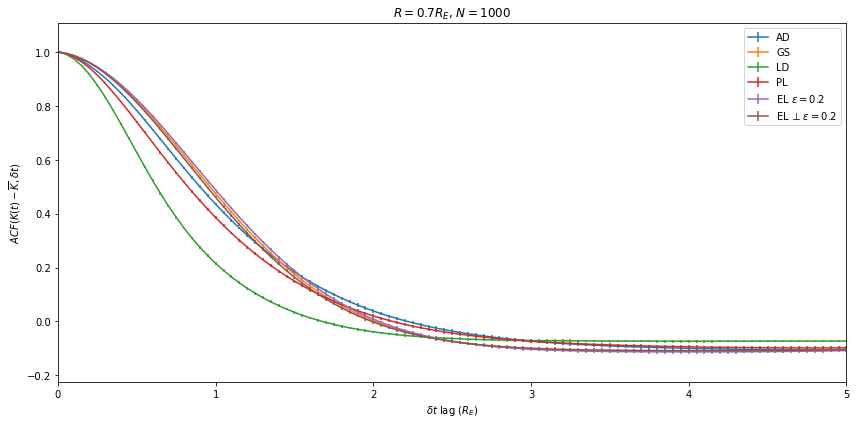

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


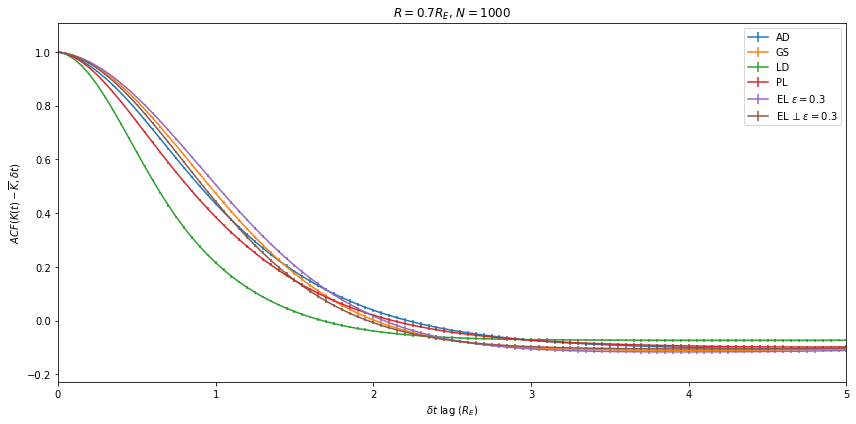

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


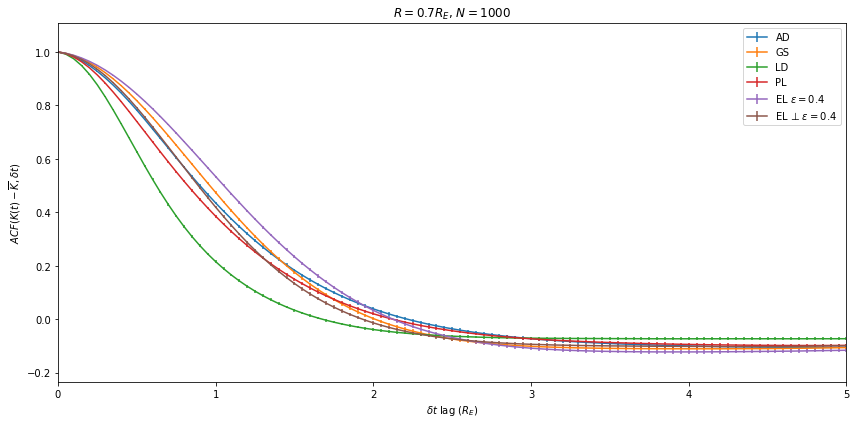

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


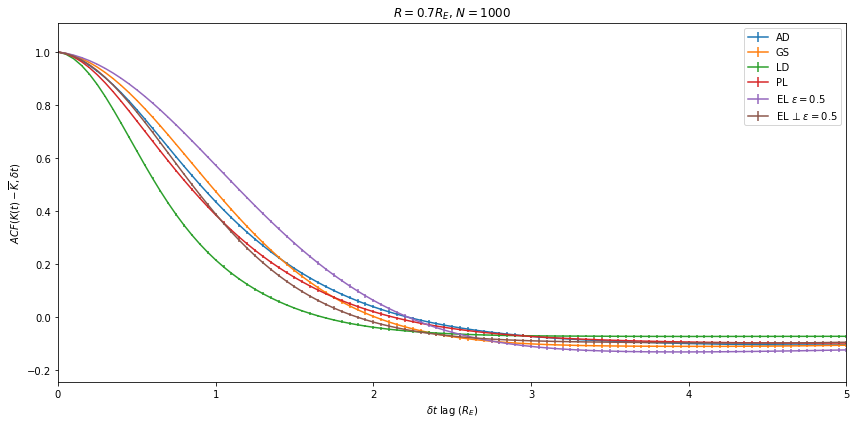

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


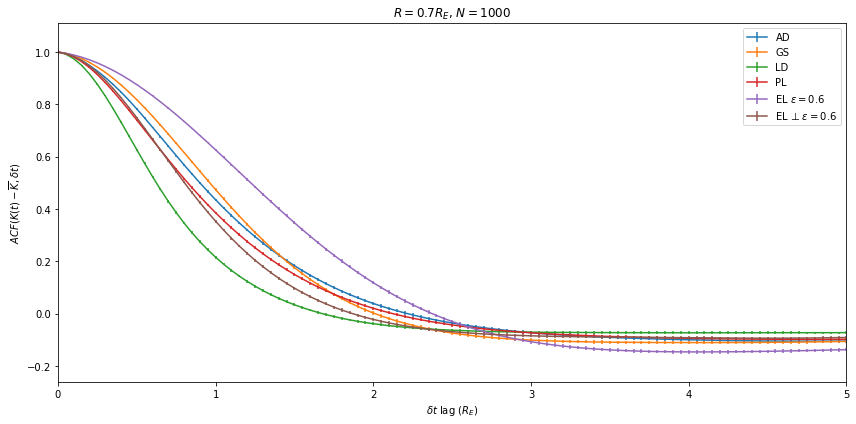

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


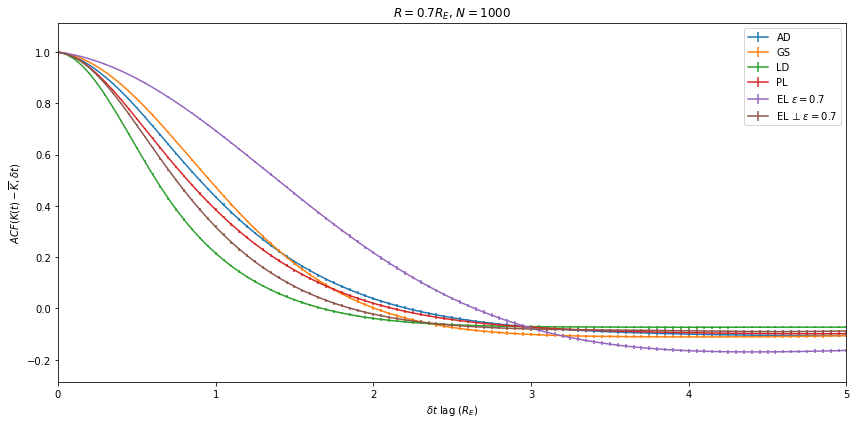

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


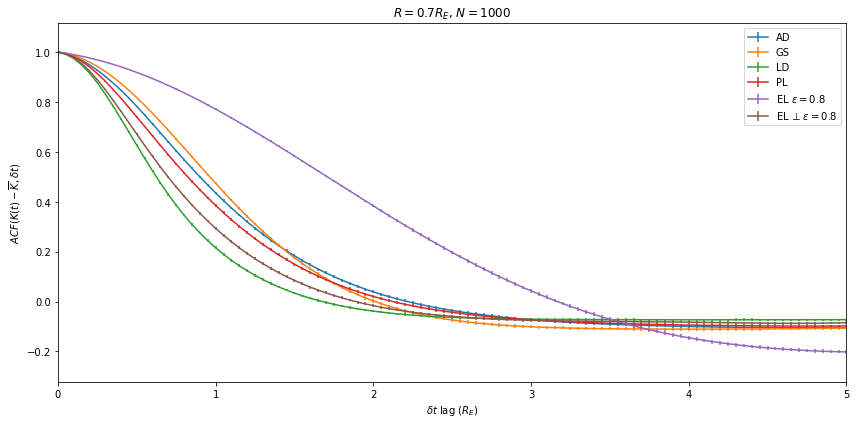

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


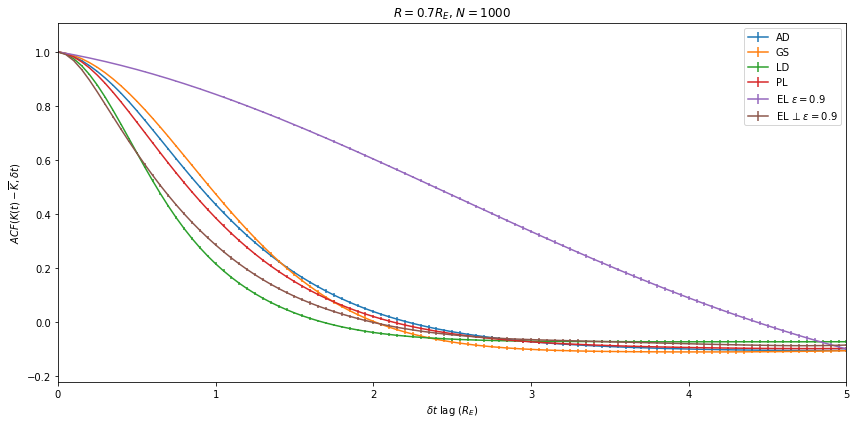

In [58]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
step = 5

for r in c0s:
    for e in c4s[r]:
        fig, ax_corr = plt.subplots(1, 1, figsize=(12, 6))
        ad, ad_err = np.mean(c0s[r], axis=0), np.std(c0s[r], axis=0)/np.sqrt(len(c0s[r]))
        gs, gs_err = np.mean(c1s[r], axis=0), np.std(c1s[r], axis=0)/np.sqrt(len(c1s[r]))
        ld, ld_err = np.mean(c2s[r], axis=0), np.std(c2s[r], axis=0)/np.sqrt(len(c2s[r]))
        pl, pl_err = np.mean(c3s[r], axis=0), np.std(c3s[r], axis=0)/np.sqrt(len(c3s[r]))
        
        el, el_err = np.mean(c4s[r][e], axis=0), np.std(c4s[r][e], axis=0)/np.sqrt(len(c4s[r][e]))
        el_orth, el_orth_err = np.mean(c5s[r][e], axis=0), np.std(c5s[r][e], axis=0)/np.sqrt(len(c5s[r][e]))
        
        ax_corr.errorbar(lags[::step], y=ad[::step], yerr=ad_err[::step],           c=colors[0], label='AD')
        ax_corr.errorbar(lags[::step], y=gs[::step], yerr=gs_err[::step],           c=colors[1], label='GS')
        ax_corr.errorbar(lags[::step], y=ld[::step], yerr=ld_err[::step],           c=colors[2], label='LD')
        ax_corr.errorbar(lags[::step], y=pl[::step], yerr=pl_err[::step],           c=colors[3], label='PL')
        ax_corr.errorbar(lags[::step], y=el[::step], yerr=el_err[::step],           c=colors[4], label='EL $\epsilon = %s$' % e)
        ax_corr.errorbar(lags[::step], y=el_orth[::step], yerr=el_orth_err[::step], c=colors[5], label='EL ⊥ $\epsilon = %s$' % e)
        ax_corr.set_title('$R=%sR_E$, $N=%s$' % (r, len(iterations)))
        ax_corr.set_xlabel('$\delta t$ lag ($R_E$)')
        ax_corr.set_ylabel('$ACF(K(t) - \overline{K}, \delta t)$')
        ax_corr.set_xlim([0, 5])
        ax_corr.autoscale_view()
        ax_corr.legend()
        autoscale_y(ax_corr)
        fig.tight_layout()
        plt.savefig('images/acf_eliptic_r%s_e%s.eps' % (r, e))
        plt.savefig('images/acf_eliptic_r%s_e%s.png' % (r, e))
        plt.show()

/data/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


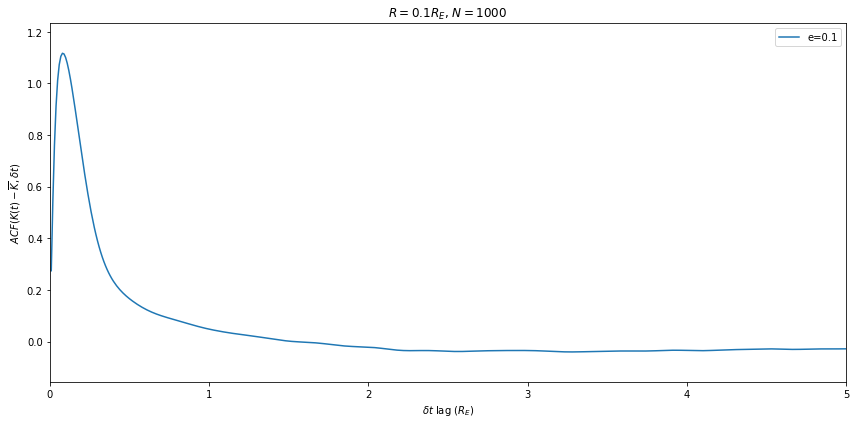

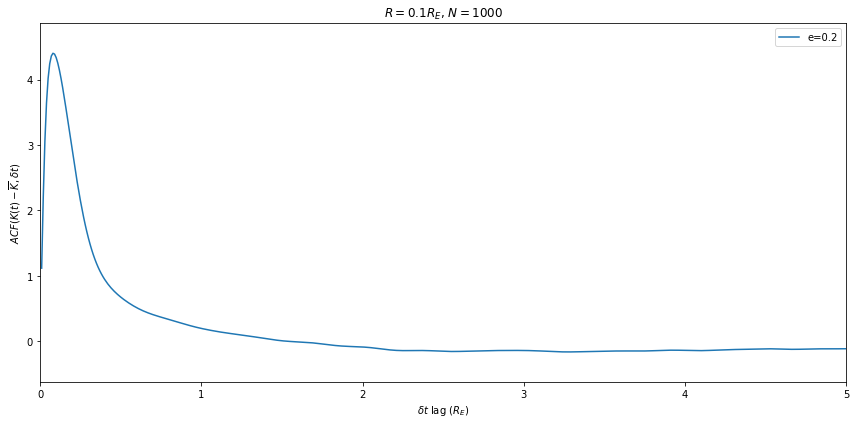

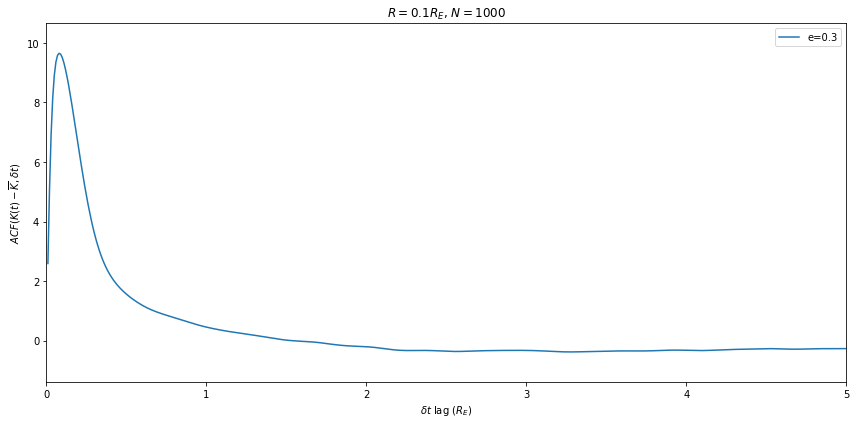

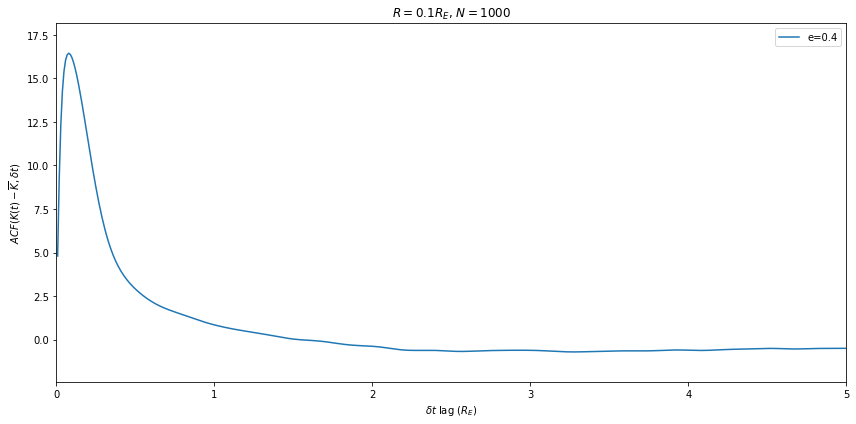

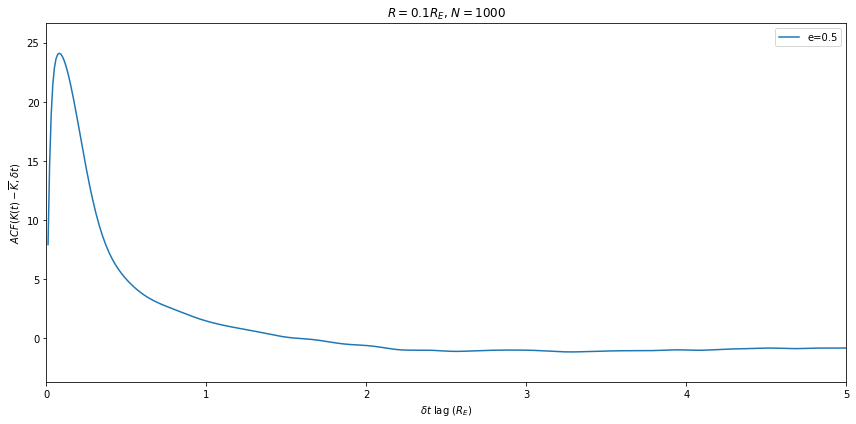

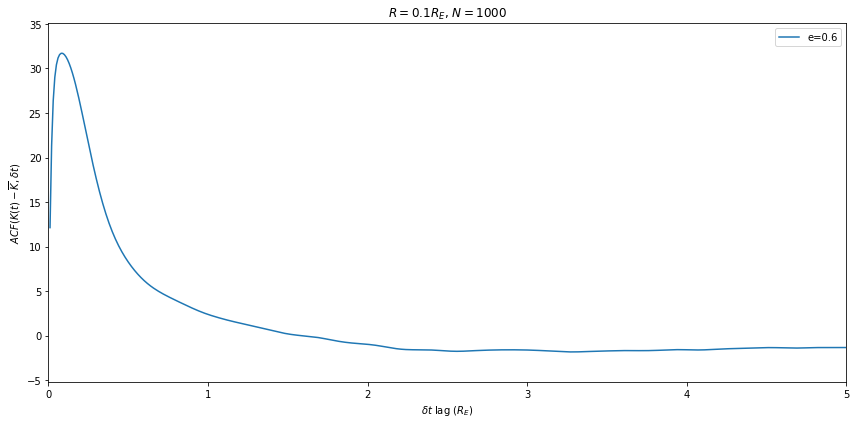

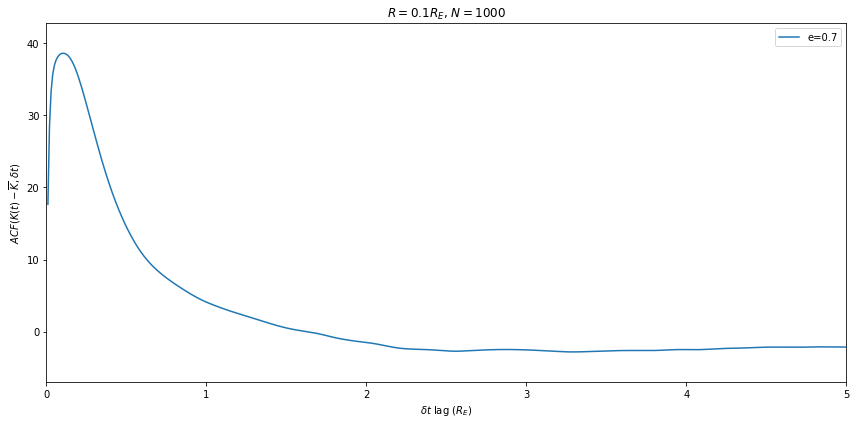

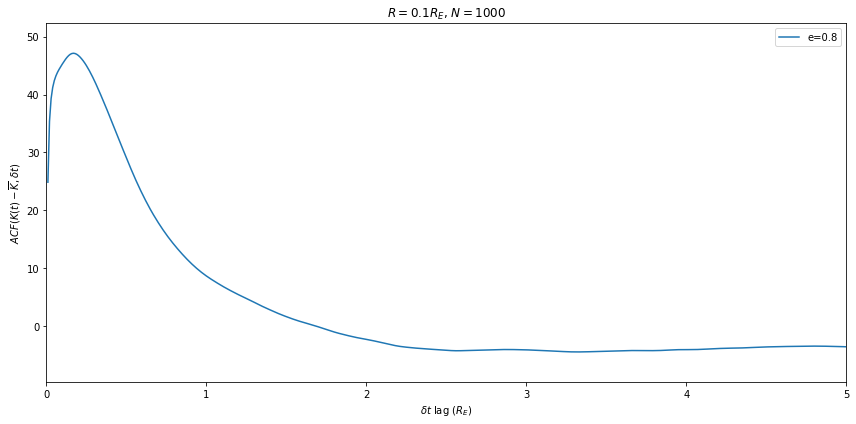

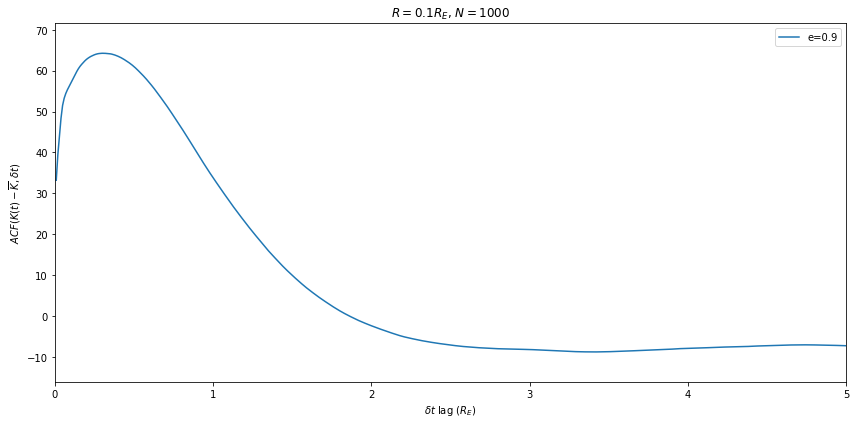

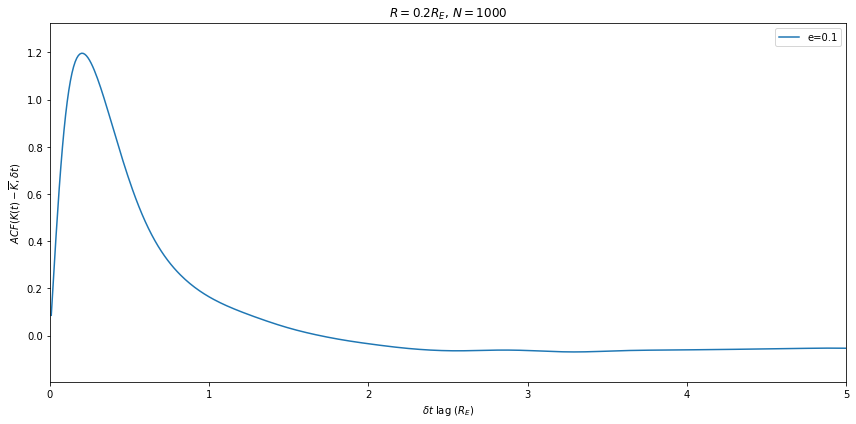

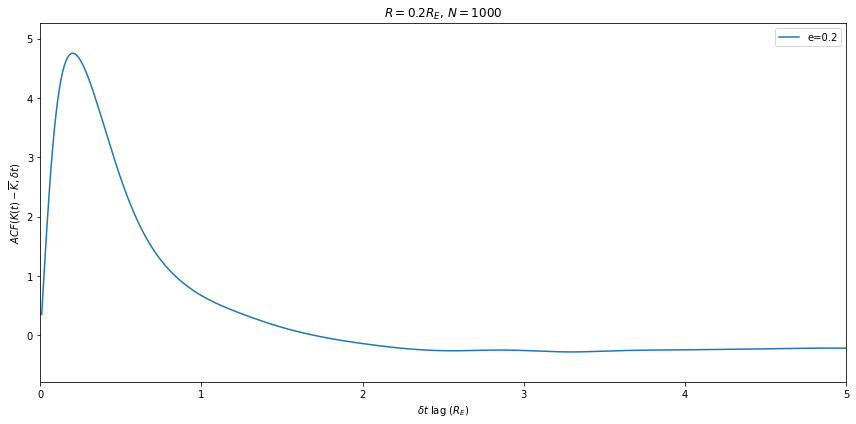

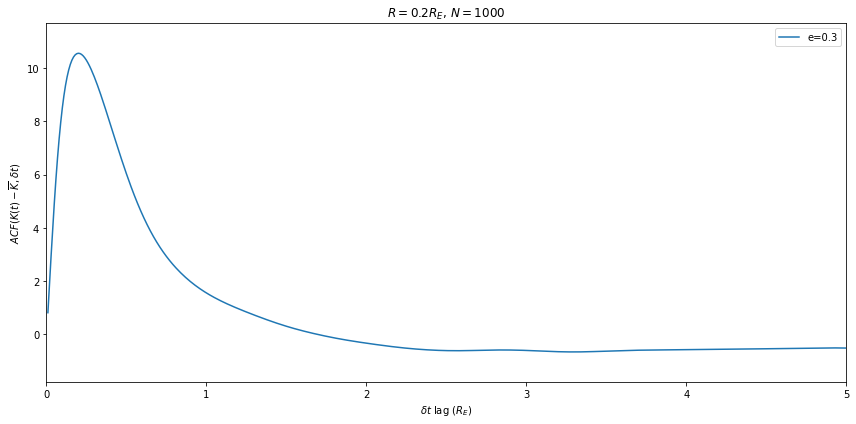

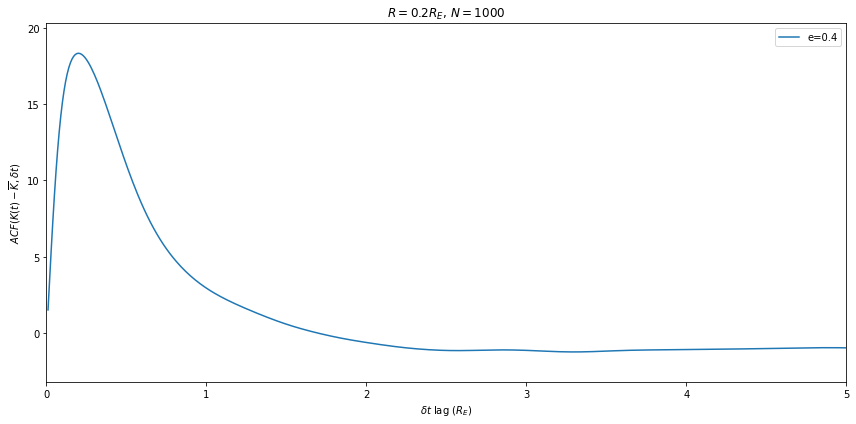

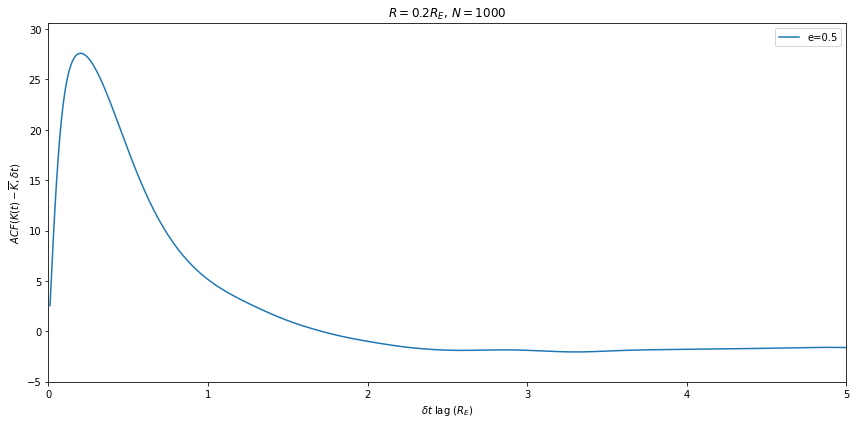

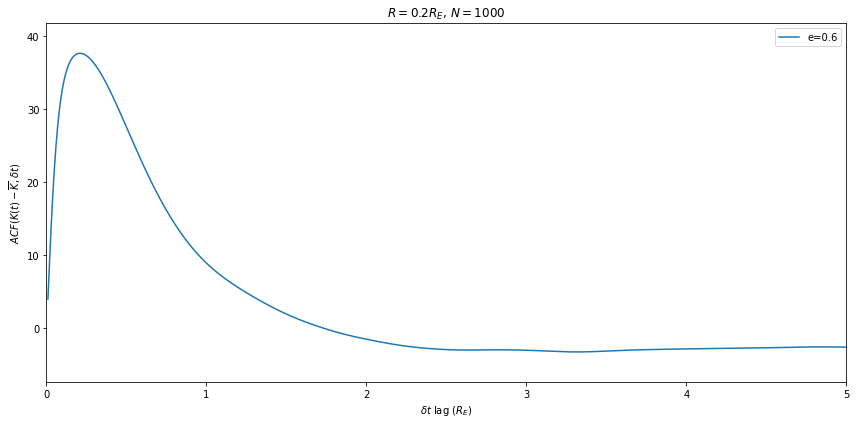

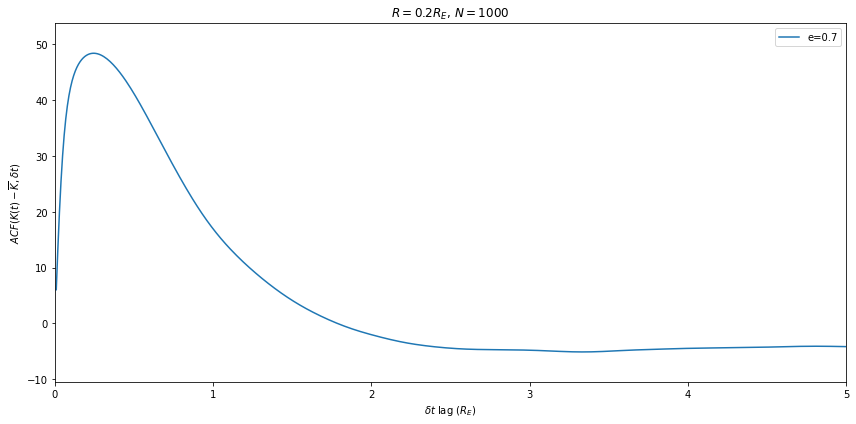

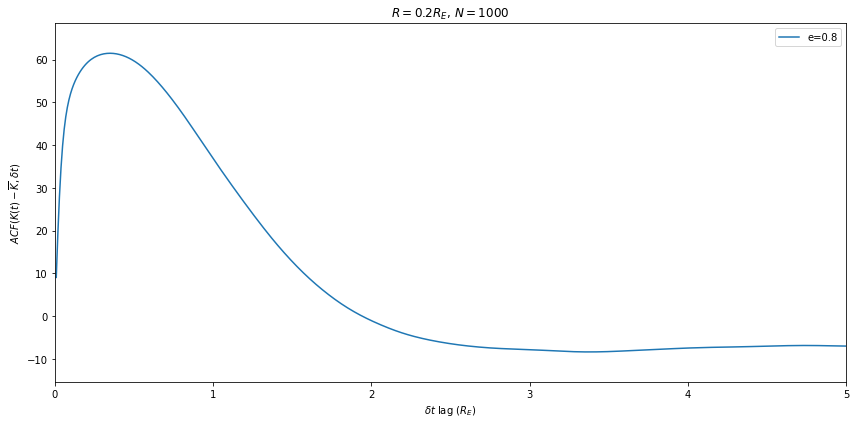

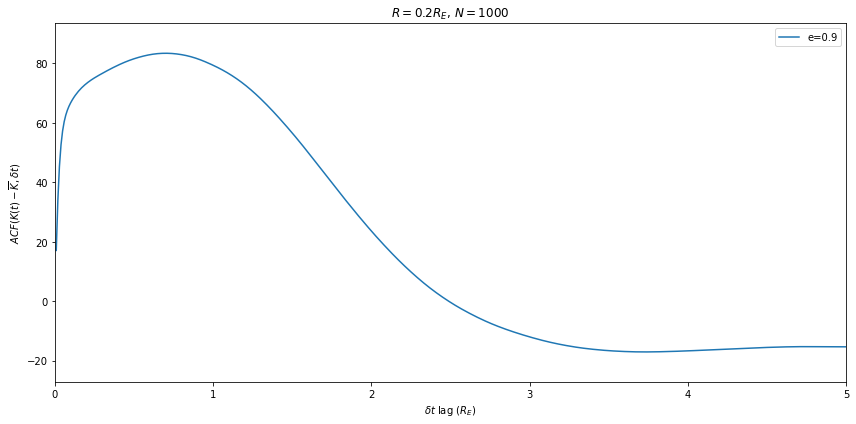

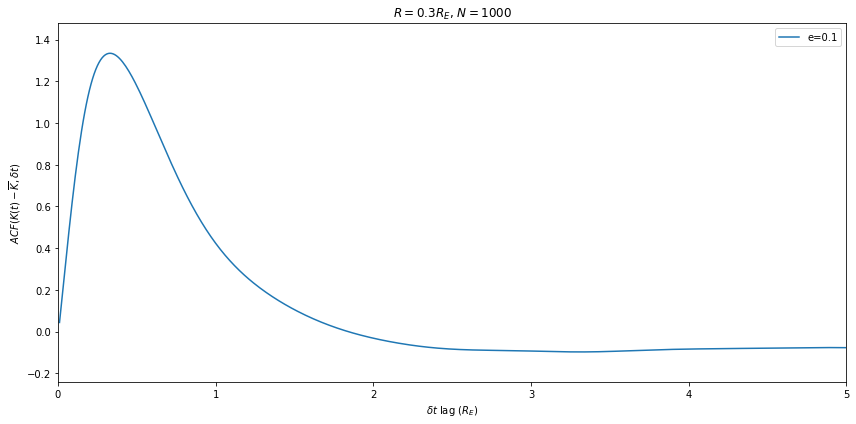

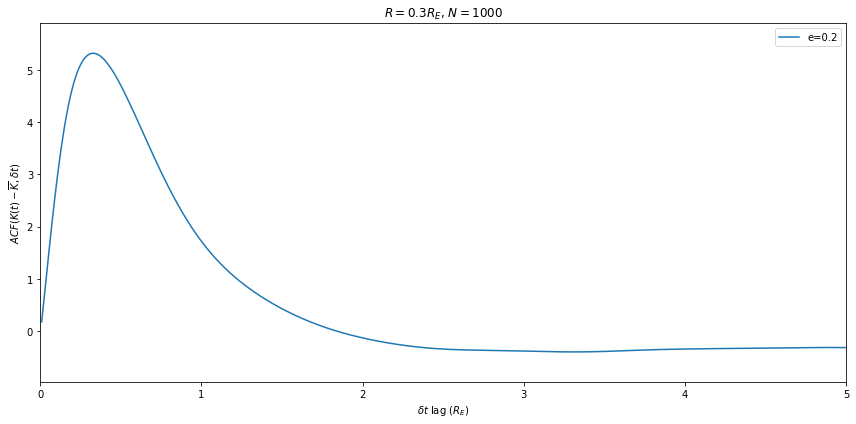

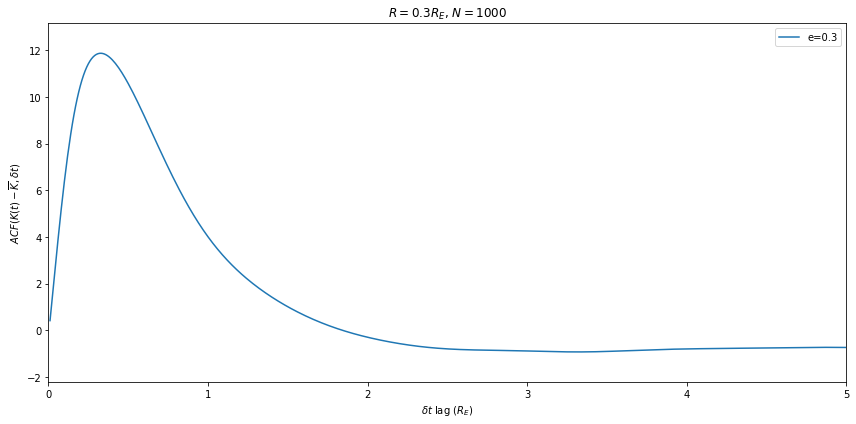

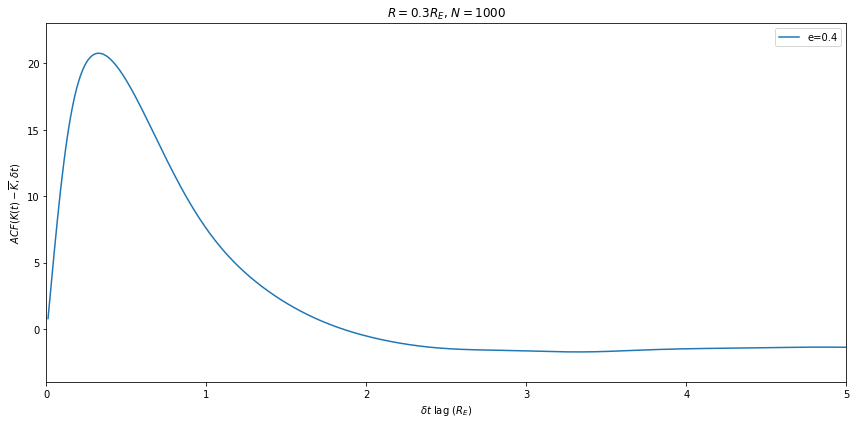

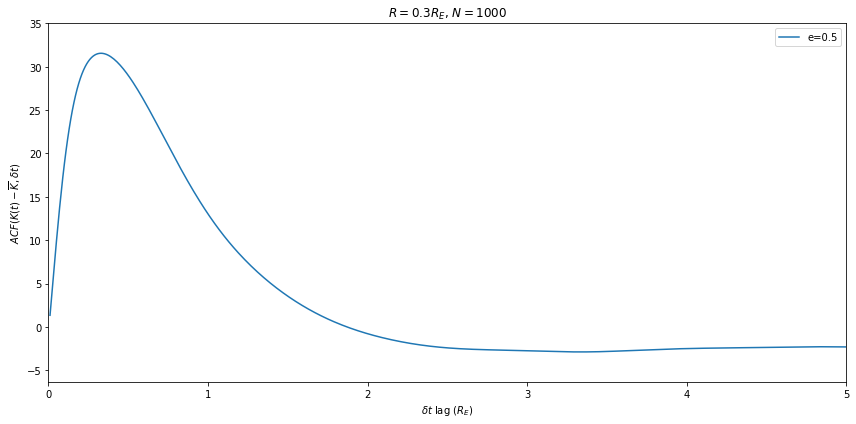

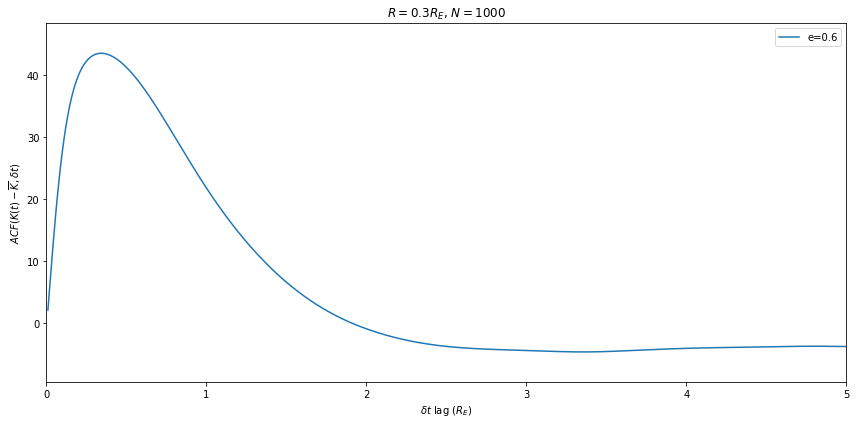

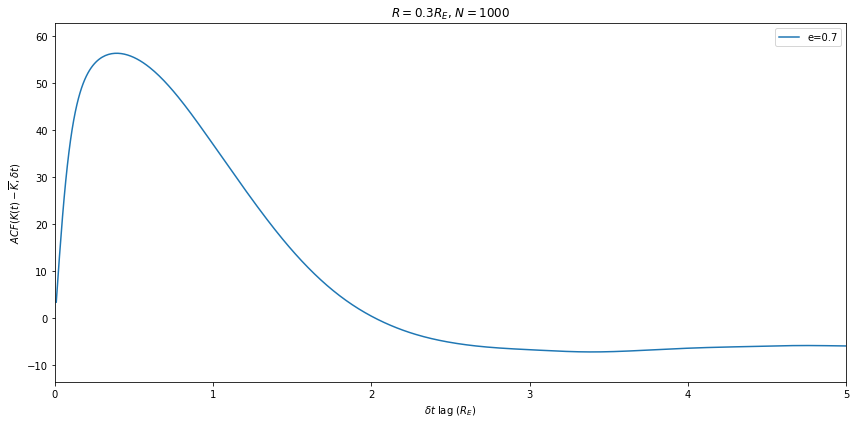

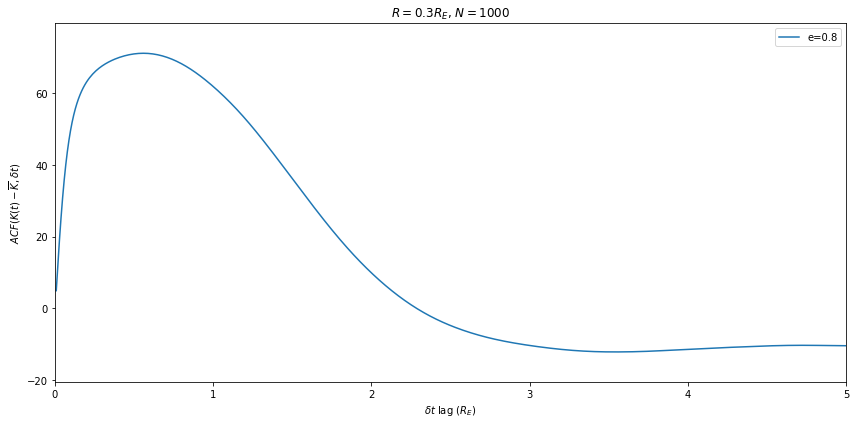

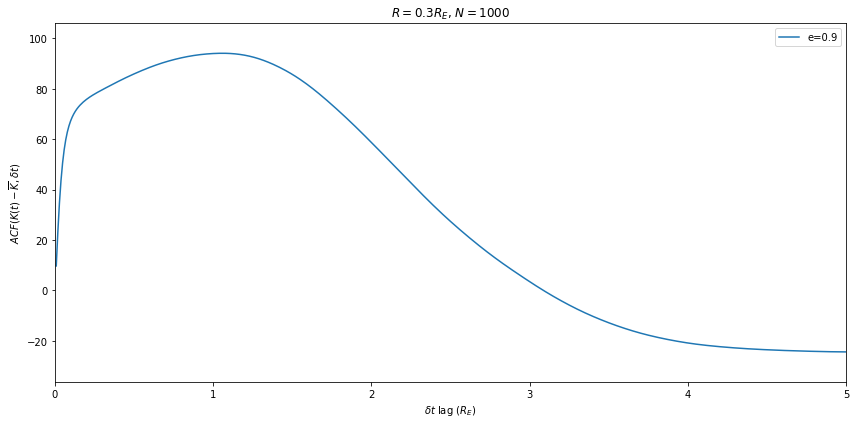

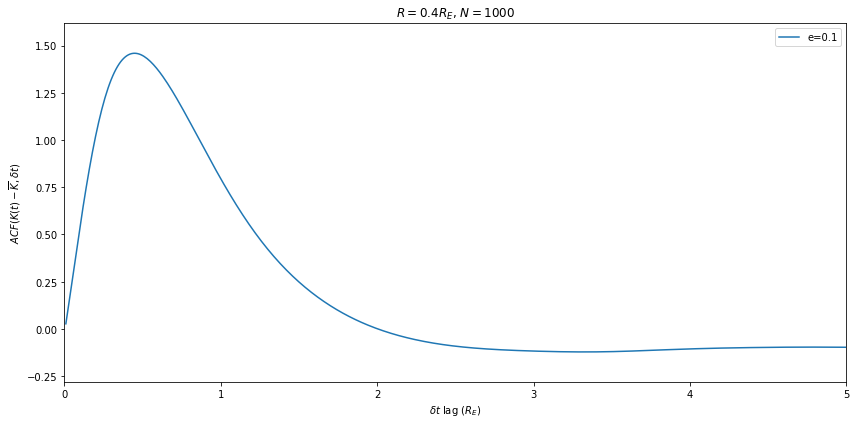

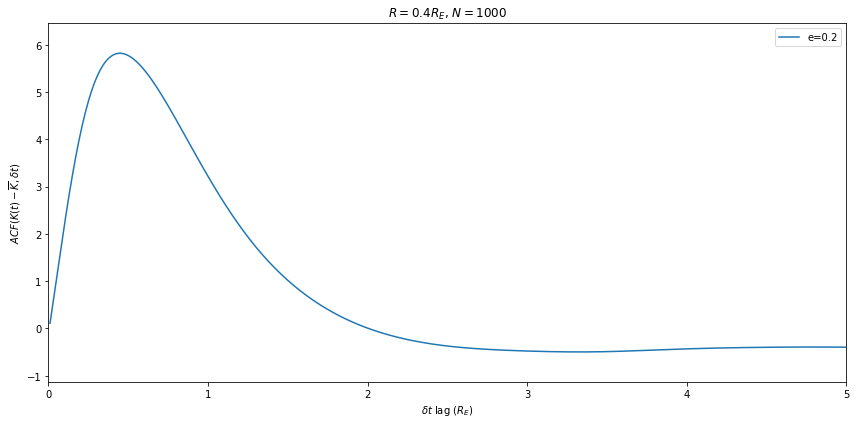

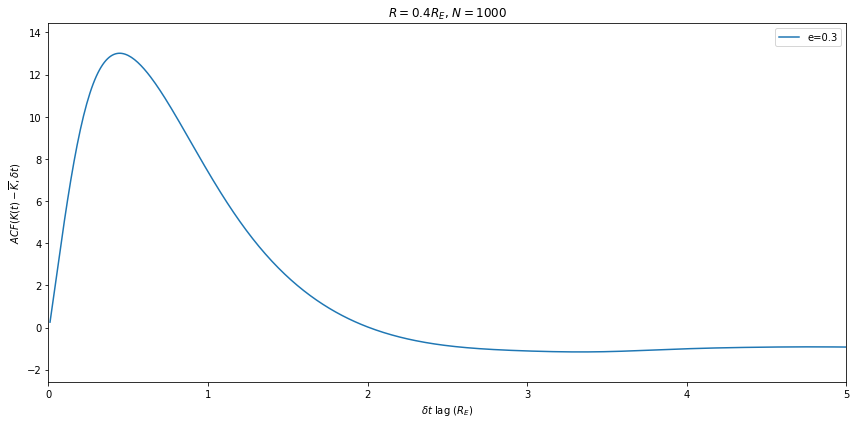

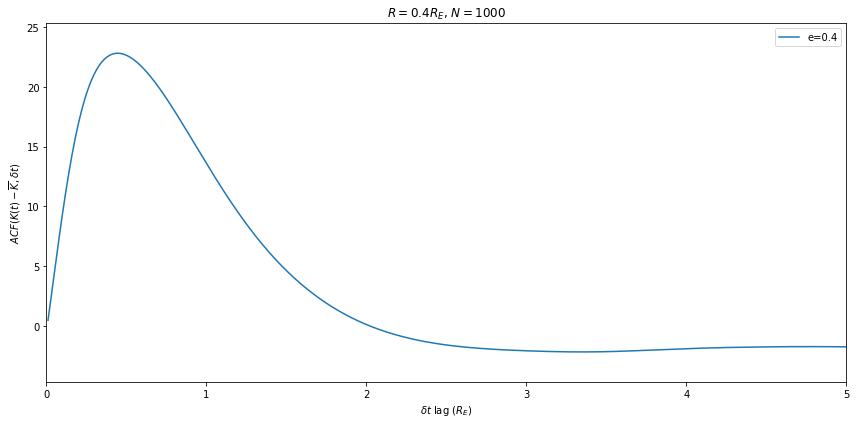

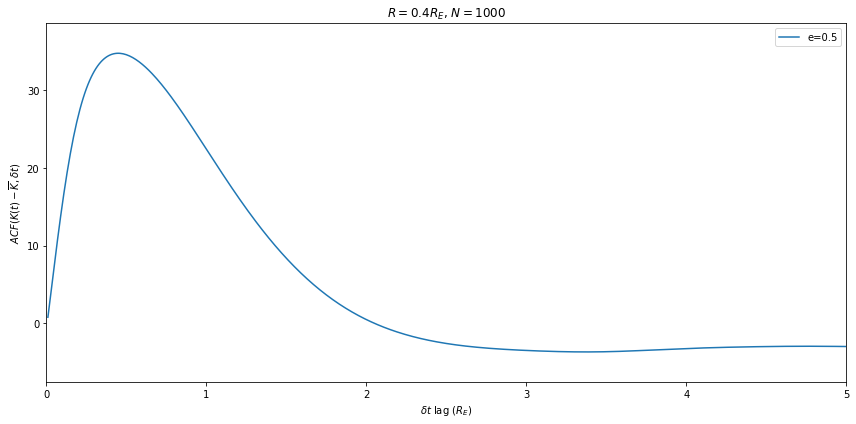

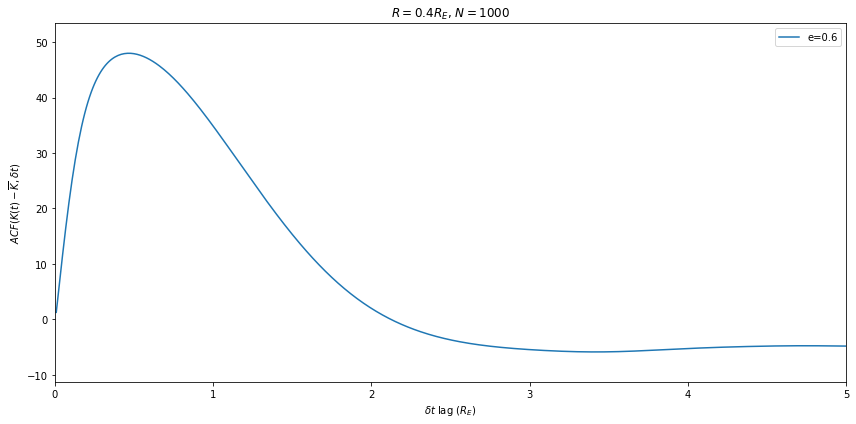

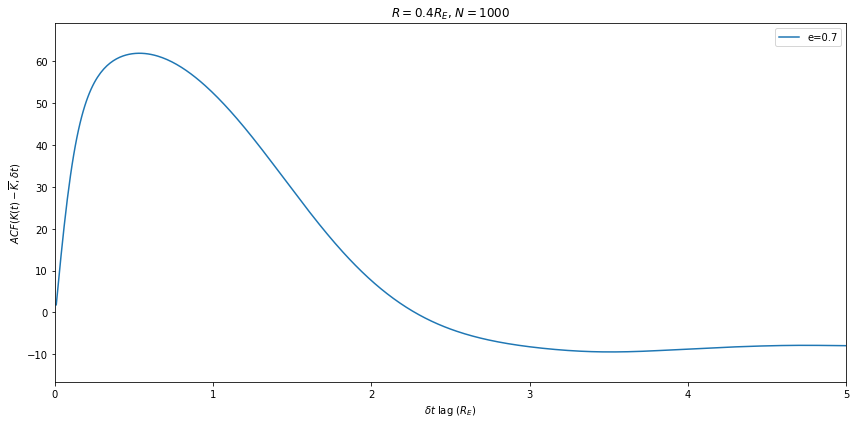

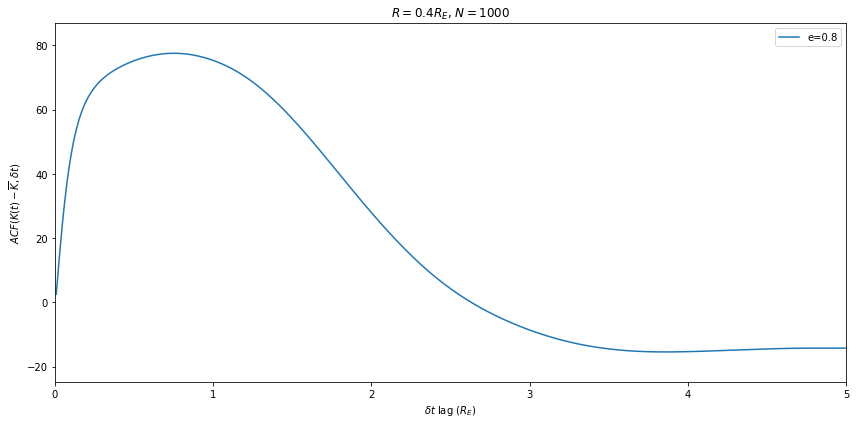

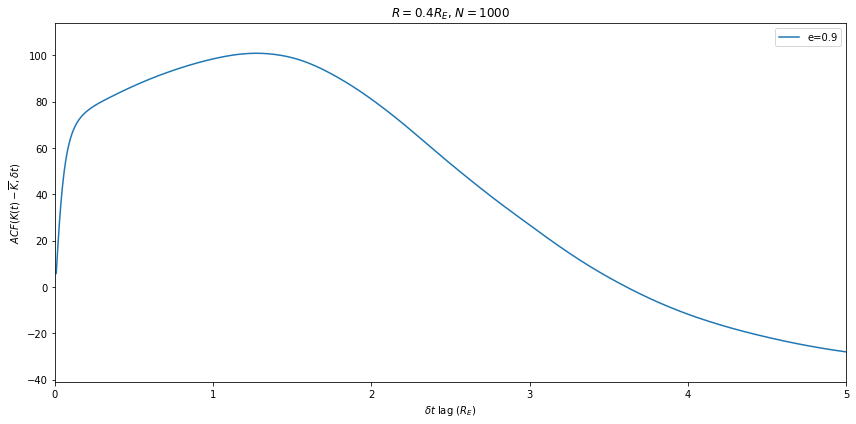

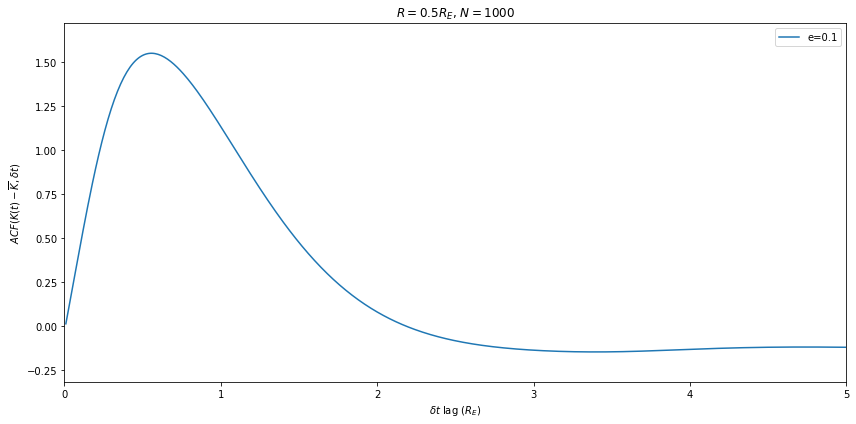

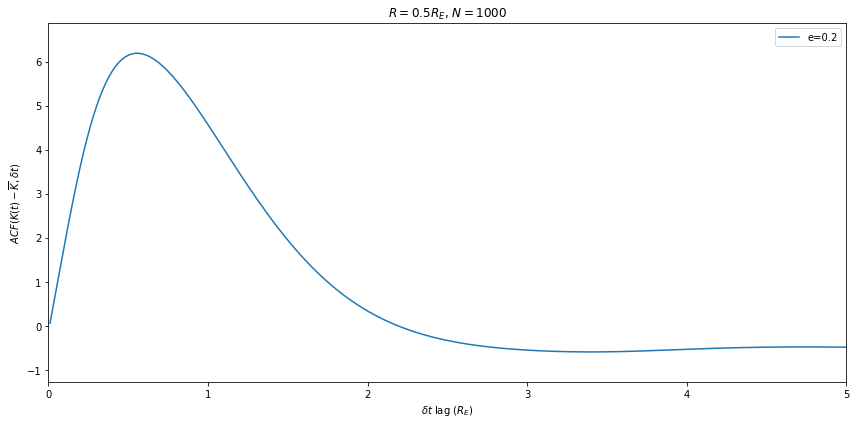

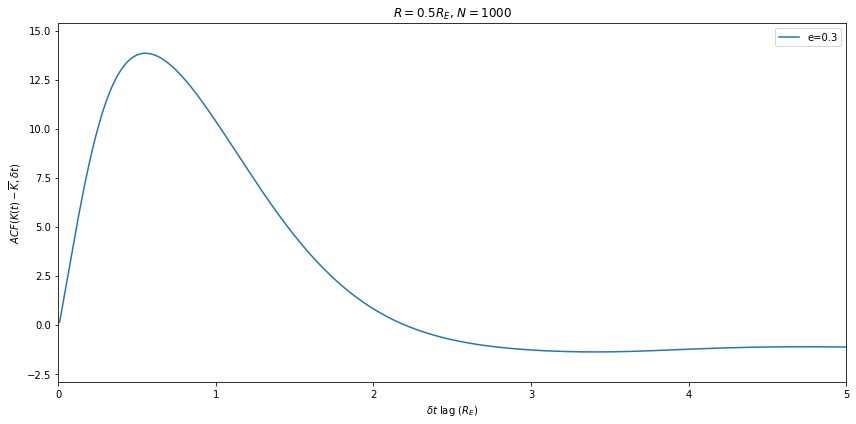

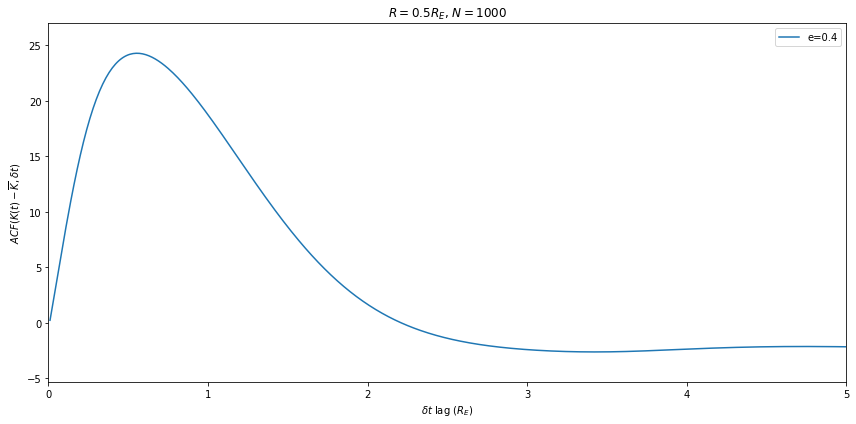

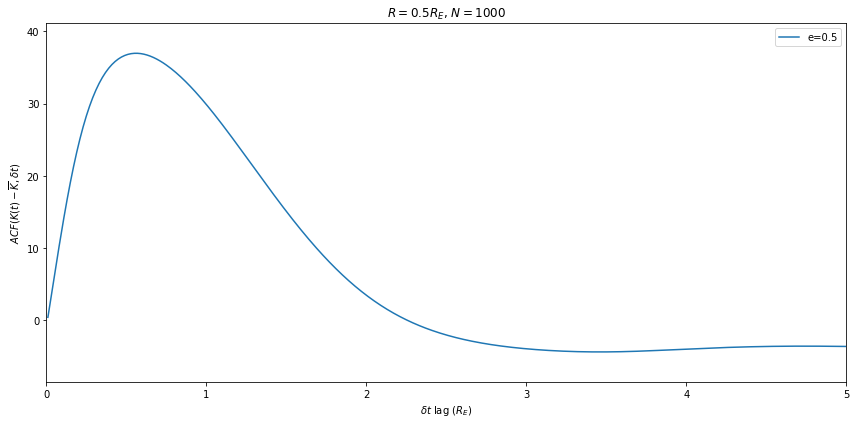

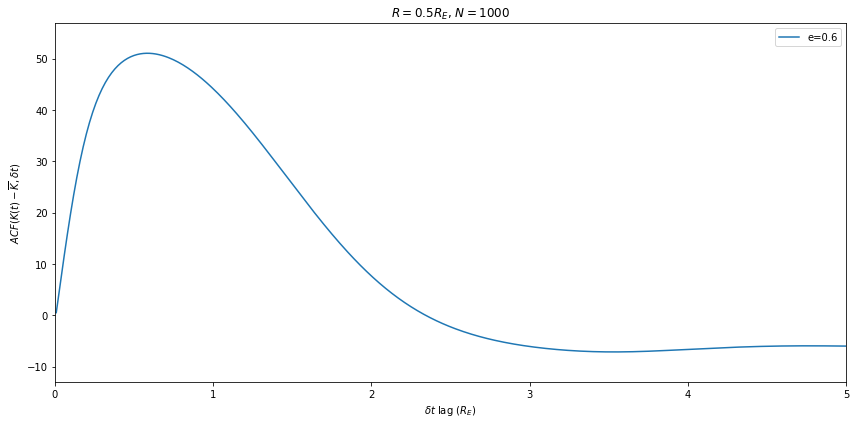

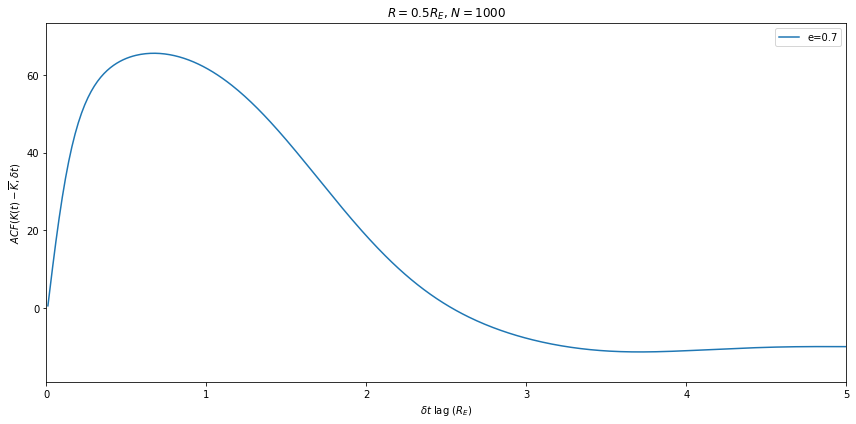

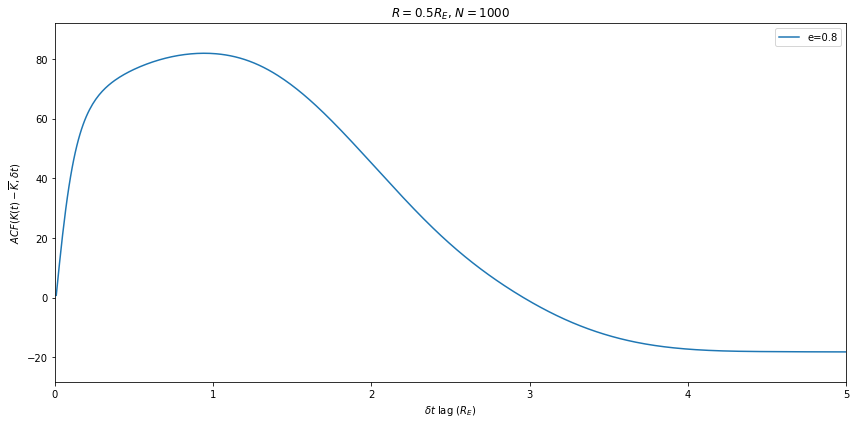

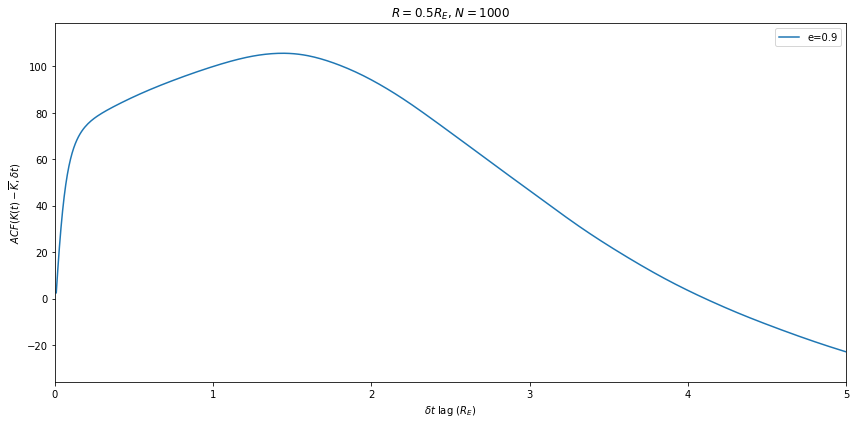

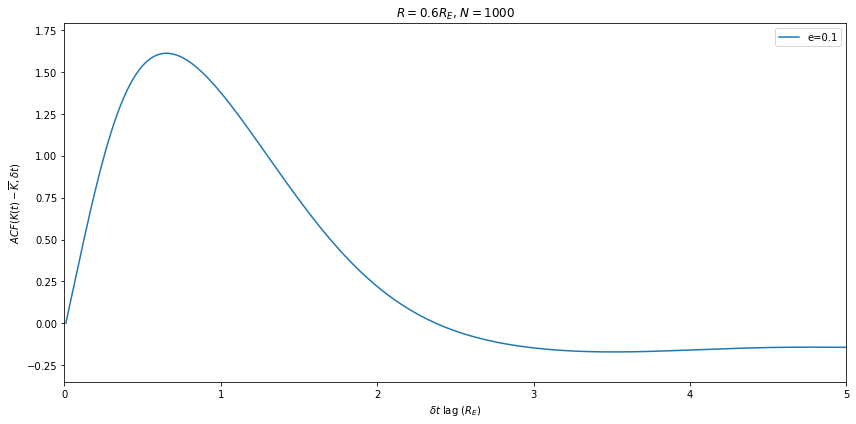

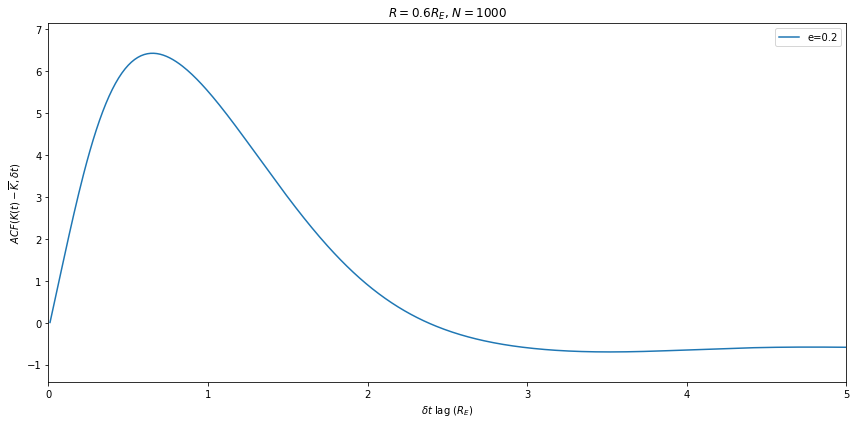

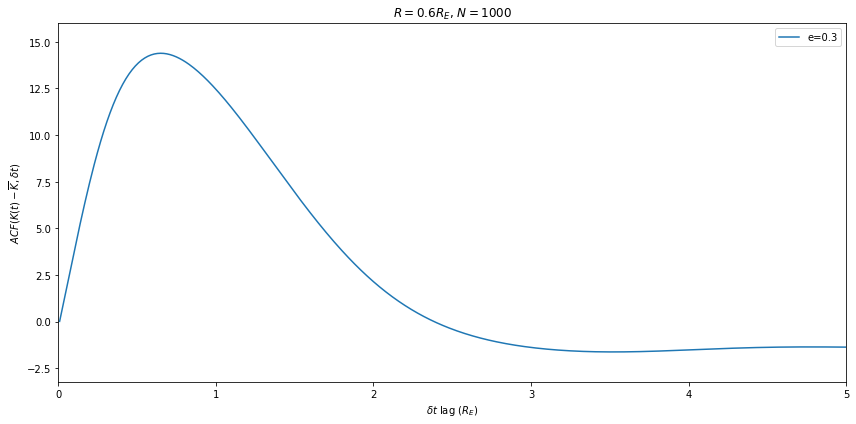

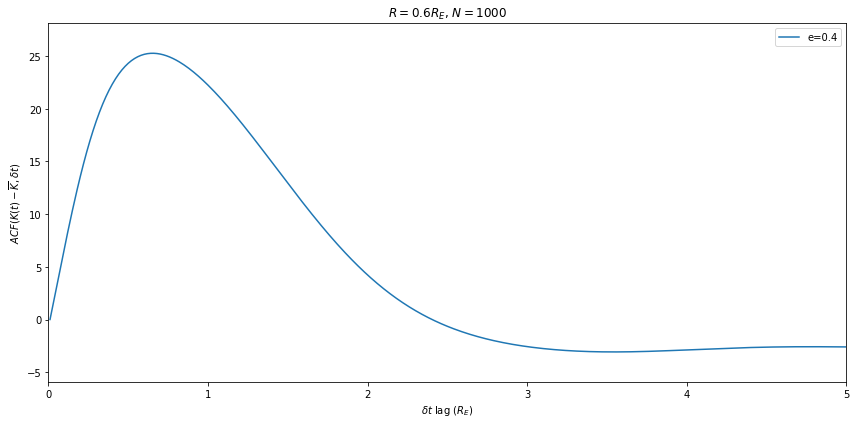

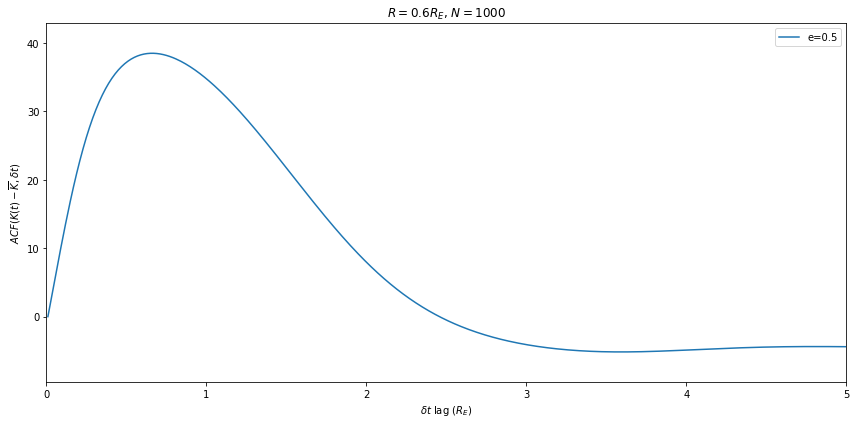

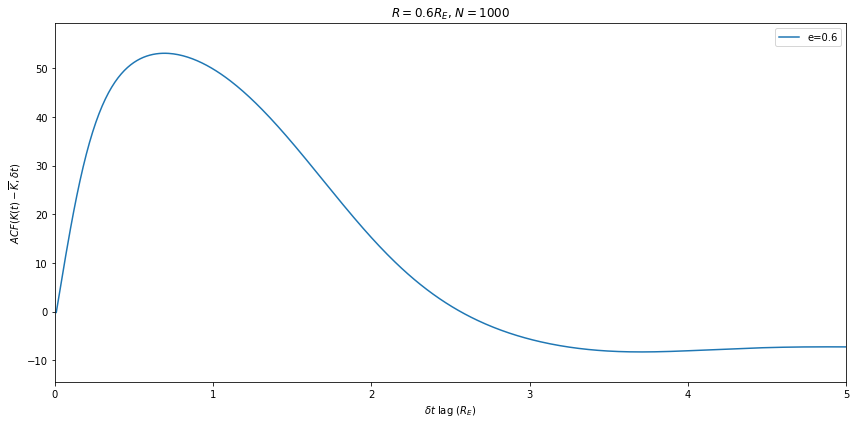

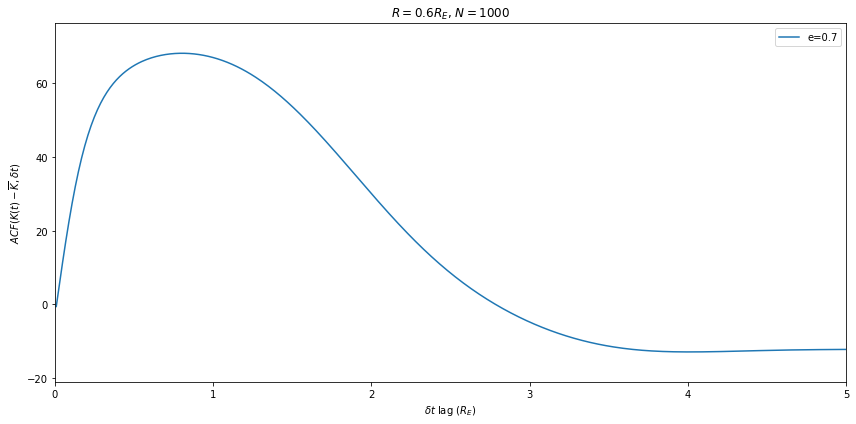

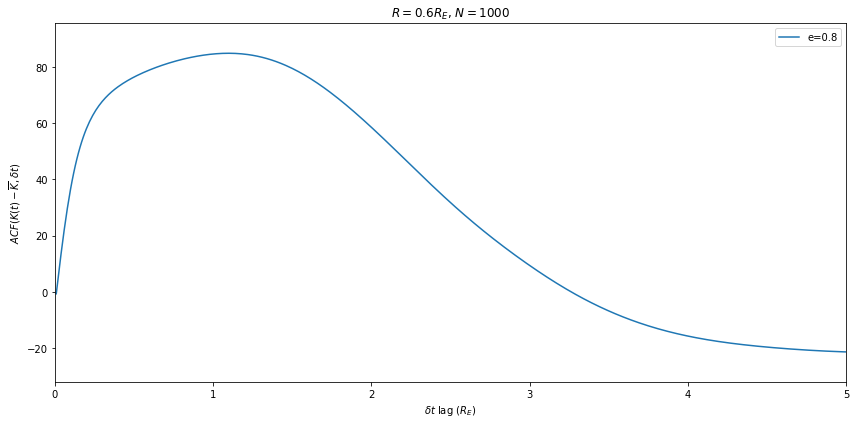

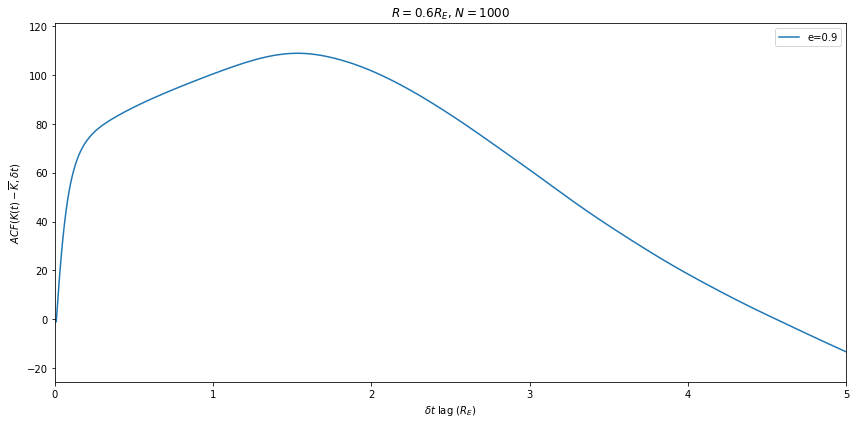

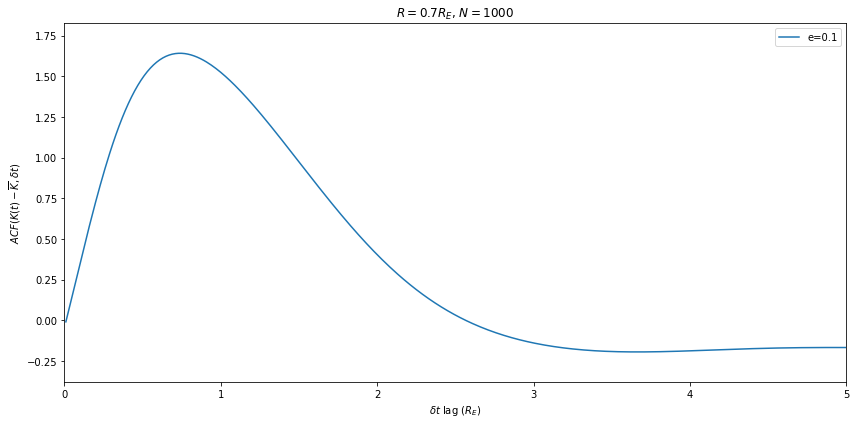

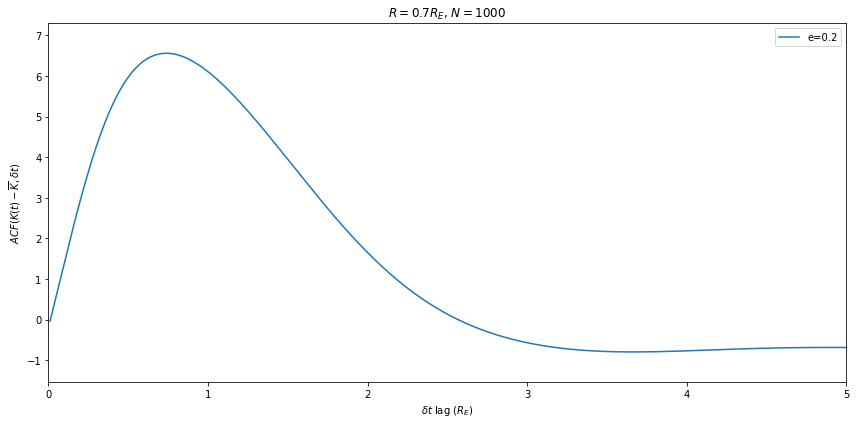

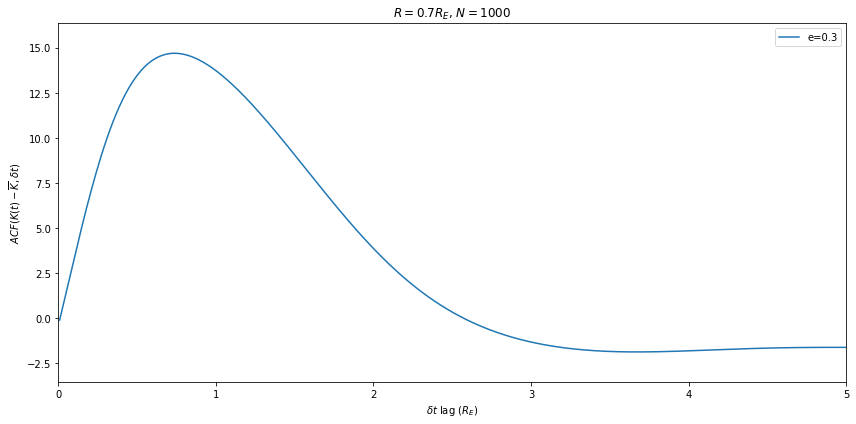

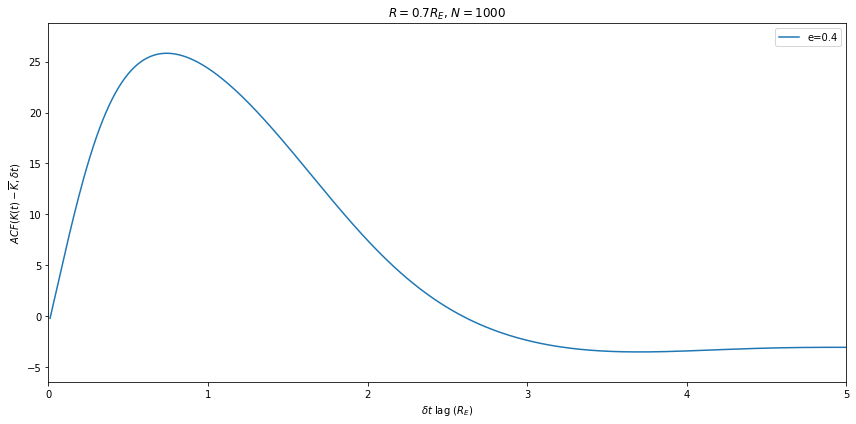

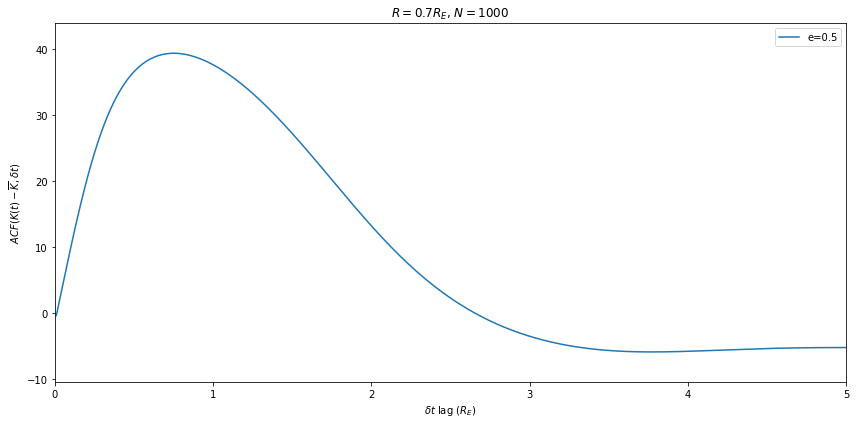

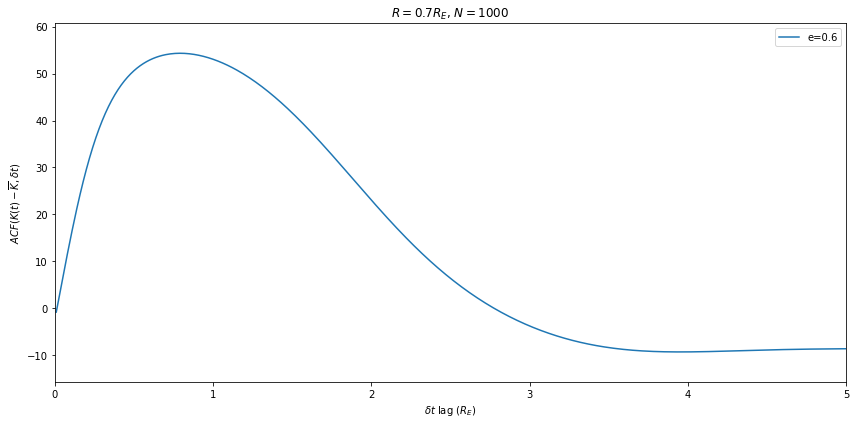

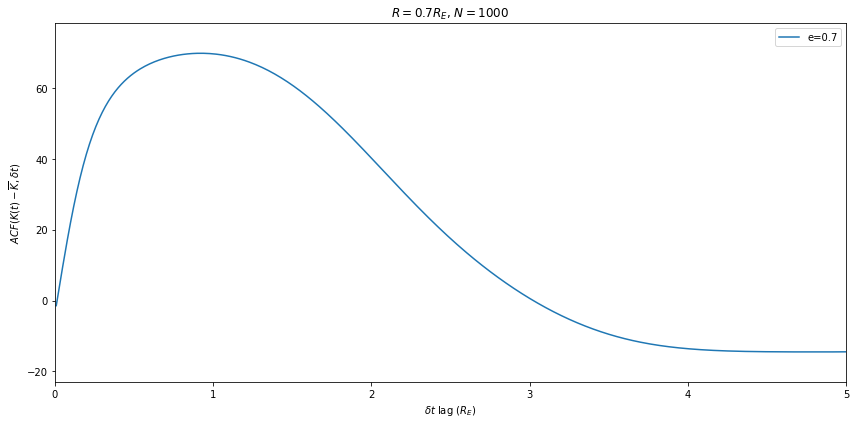

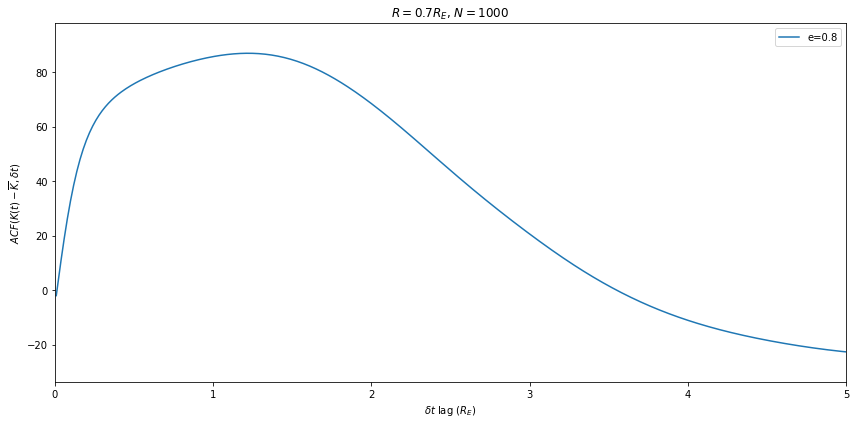

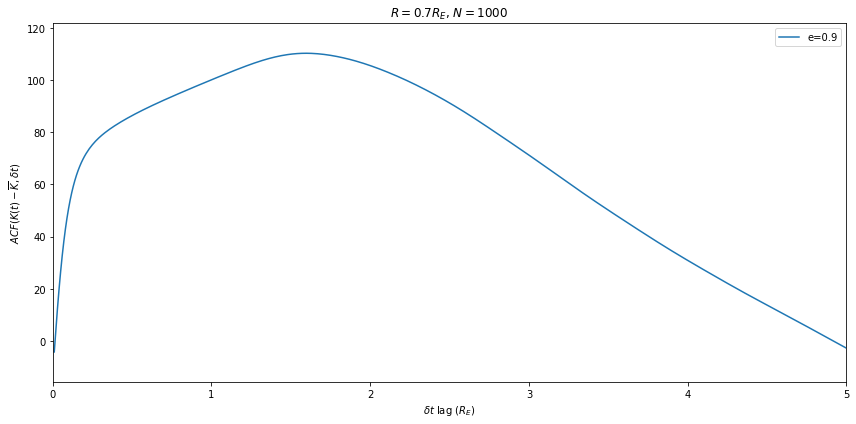

In [60]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
step = 5

data = []

for r in c0s:
    for e in c4s[r]:
        fig, ax_corr = plt.subplots(1, 1, figsize=(12, 6))
        ad, ad_err = np.mean(c0s[r], axis=0), np.std(c0s[r], axis=0)/np.sqrt(len(c0s[r]))
        gs, gs_err = np.mean(c1s[r], axis=0), np.std(c1s[r], axis=0)/np.sqrt(len(c1s[r]))
        ld, ld_err = np.mean(c2s[r], axis=0), np.std(c2s[r], axis=0)/np.sqrt(len(c2s[r]))
        pl, pl_err = np.mean(c3s[r], axis=0), np.std(c3s[r], axis=0)/np.sqrt(len(c3s[r]))
        
        el, el_err = np.mean(c4s[r][e], axis=0), np.std(c4s[r][e], axis=0)/np.sqrt(len(c4s[r][e]))
        el_orth, el_orth_err = np.mean(c5s[r][e], axis=0), np.std(c5s[r][e], axis=0)/np.sqrt(len(c5s[r][e]))
        
        #ax_corr.errorbar(lags[::step], y=ad[::step], yerr=ad_err[::step],           c=colors[0], label='AD')
        #ax_corr.errorbar(lags[::step], y=gs[::step], yerr=gs_err[::step],           c=colors[1], label='GS')
        #ax_corr.errorbar(lags[::step], y=ld[::step], yerr=ld_err[::step],           c=colors[2], label='LD')
        #ax_corr.errorbar(lags[::step], y=pl[::step], yerr=pl_err[::step],           c=colors[3], label='PL')
        #ax_corr.errorbar(lags[::step], y=el[::step], yerr=el_err[::step],           c=colors[4], label='EL $\epsilon = %s$' % e)
        #ax_corr.errorbar(lags[::step], y=el_orth[::step], yerr=el_orth_err[::step], c=colors[5], label='EL ⊥ $\epsilon = %s$' % e)
        
        d = (el - el_orth)/el_orth_err
        dm = np.nanmax(d)
        lm = lags[d == dm][0]
        ax_corr.errorbar(lags, y=d,           c=colors[0], label='e=%s' % e)
        data.append([float(r), float(e), dm, lm])
        ax_corr.set_title('$R=%sR_E$, $N=%s$' % (r, len(iterations)))
        ax_corr.set_xlabel('$\delta t$ lag ($R_E$)')
        ax_corr.set_ylabel('$ACF(K(t) - \overline{K}, \delta t)$')
        ax_corr.set_xlim([0, 5])
        ax_corr.autoscale_view()
        ax_corr.legend()
        autoscale_y(ax_corr)
        fig.tight_layout()
        #plt.savefig('images/acf_eliptic_r%s_e%s.eps' % (r, e))
        #plt.savefig('images/acf_eliptic_r%s_e%s.png' % (r, e))
        plt.show()
data = np.array(data)

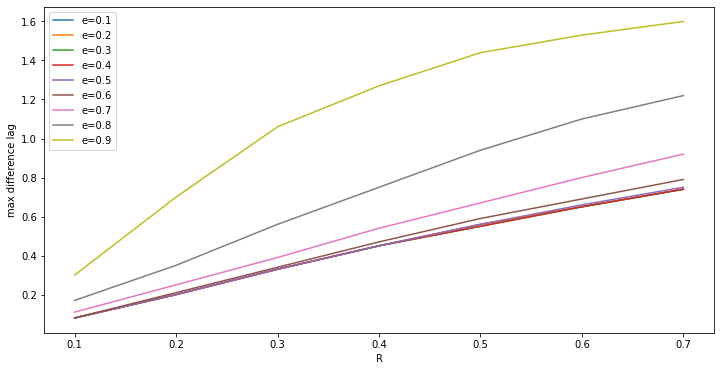

In [61]:
fig = plt.figure(figsize=(12,6))
for e in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(data[:,0][data[:,1] == e], data[:,3][data[:,1] == e], '-', label='e=%s' % e)

plt.ylabel('max difference lag')
plt.xlabel('R')
plt.legend()
plt.show()

/data/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


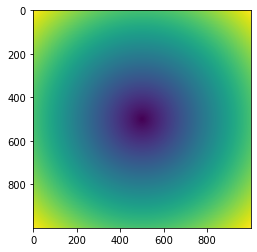

In [199]:
source_size = 0.1

p_ld = 2.0
p_pl = 1.5

R_gs = source_size
R2_gs = R_gs * R_gs

R_1_2_ld = source_size * np.sqrt(np.log(2.0))
R_ld = R_1_2_ld / np.sqrt(1.0 - np.power(0.5, 2)/(p_ld + 2))
R2_ld = R_ld * R_ld

R_1_2_pl = source_size * np.sqrt(np.log(2.0))
R_pl = R_1_2_pl / np.sqrt((np.power(2.0, 1.0/(p_pl - 1)) - 1.0)/np.log(2.0))
R2_pl = R_pl * R_pl

R_1_2_ad = source_size * np.sqrt(np.log(2.0))
R_ad = R_1_2_ad/4.0
R2_ad = R_ad * R_ad

def H(x):
    y = np.ones_like(x)
    y[x < 0] = 0.0
    return y

import math

d = np.arange(0, 2, 0.01)

def get_values(d):
    d2 = np.power(d, 2)
    
    
    factorex_gs = np.exp(- d2 / R2_gs)
    factorex_ld = ((p_ld + 1)/(np.pi * R2_ld)) * H(1 - d2/R2_ld) * pow(1 - d2/R2_ld, p_ld)
    factorex_pl = ((p_pl - 1)/(np.pi * R2_pl)) * (1/pow(1 + d2/R2_pl, p_pl))
    factorex_ad = (3 * R_ad  / (2 * np.pi * np.power(d, 3))) * (1 - np.sqrt(R_ad/d))
    factorex_ad[np.abs(d) < R_ad] = 0.0

    factorex_ad = factorex_ad/np.max(factorex_ad)
    factorex_gs = factorex_gs/np.max(factorex_gs)
    factorex_pl = factorex_pl/np.max(factorex_pl)
    factorex_ld = factorex_ld/np.max(factorex_ld)
    
    return factorex_ad, factorex_gs, factorex_pl, factorex_ld

data = []
x = np.arange(-0.5, 0.5, 0.001)
y = np.arange(-0.5, 0.5, 0.001)
for _x in x:
    d = np.sqrt(np.power(_x, 2) + np.power(y, 2))
    v = get_values(d)
    data.append(d)
plt.imshow(data)

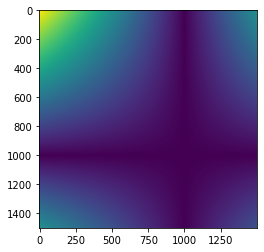

In [163]:
plt.imshow(np.sqrt(np.einsum('j,i', np.power(x, 2), np.power(y, 2))))

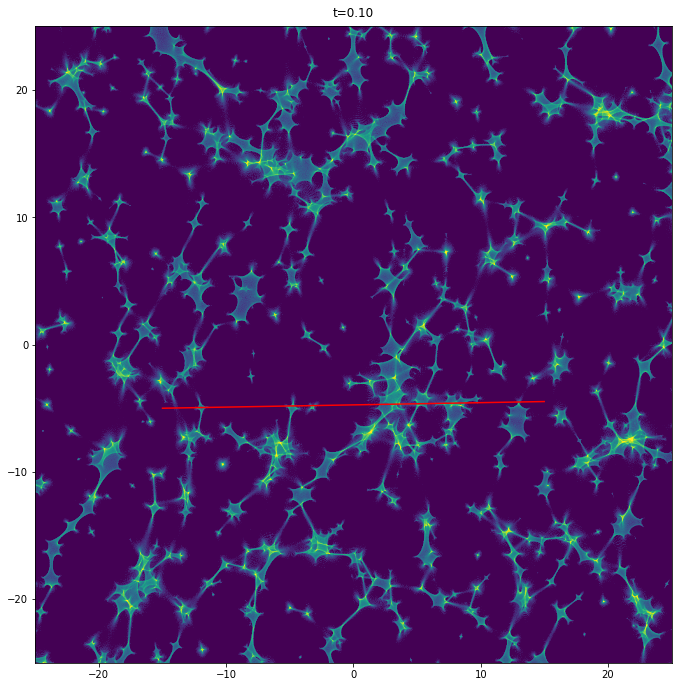

In [83]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 12), gridspec_kw={'height_ratios': [10]})
fig.tight_layout()
fig.subplots_adjust(left=0.09, top=0.98)

t = 0.1
filename1 = f"output/reference_test/image_%.2f.dat" % t
img, extent = get_image_data(filename1, logscale=True)
img[img < 0.1] = 0
title = ax1.text(0.5, 1.01, "t=%.2f" % t, ha="center",va="bottom", transform=ax1.transAxes, fontsize="large")
line1 = ax1.imshow(img, interpolation='antialiased', extent=extent, origin='lower', vmin=1, vmax=2)
ax1.plot(lc['y1'], lc['y2'], color='red')
plt.show()
plt.close()

t=0.00


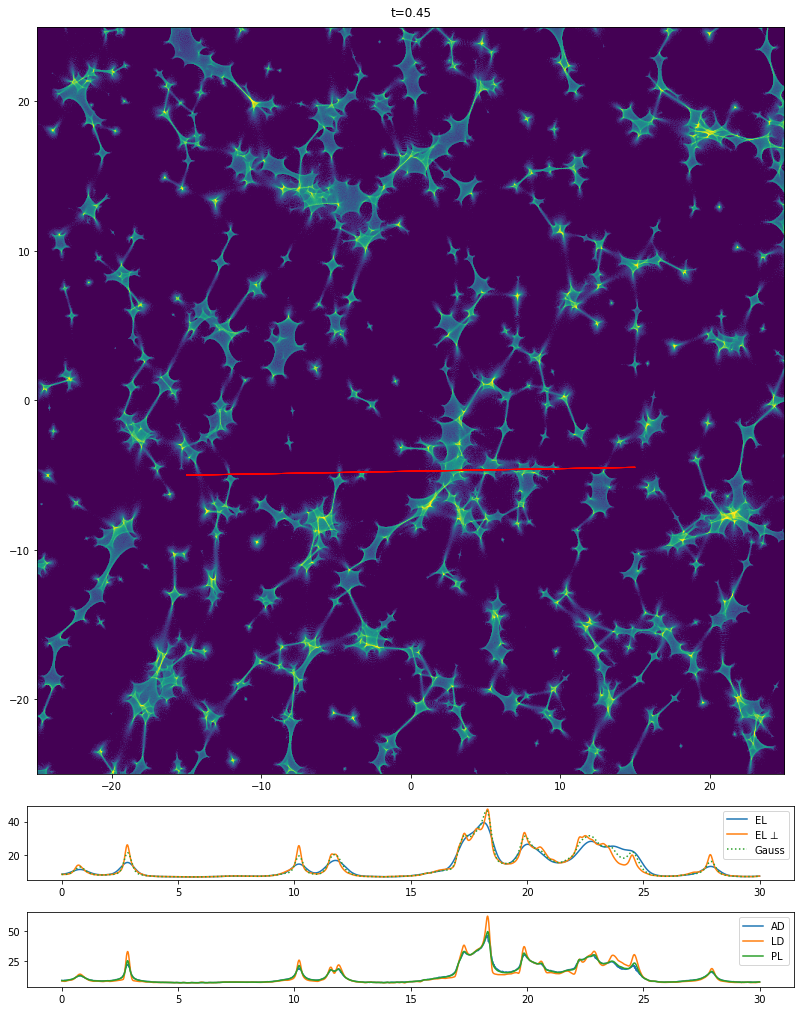

In [87]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [12, 1.2, 1.2]})
fig.tight_layout()
fig.subplots_adjust(left=0.09, top=0.98)

iterations = np.arange(0, 5, 0.05)
r = 0.2
e = 0.7
sigma = 0.5
moving_stars = True

ims = []
max_ampl = []
s_max = 0
for t in iterations:
    if 10 * t % 10 == 0:
        print("t=%.2f" % t)
    filename1 = f"output/reference_test/image_%.2f.dat" % t
    filename2 = f"output/reference_test/lc_%.2f.dat" % t
    img, extent = get_image_data(filename1, logscale=True)
    lc = get_lc_data(filename2)
    title = ax1.text(0.5, 1.01, "t=%.2f" % t, ha="center",va="bottom", transform=ax1.transAxes, fontsize="large")
    line1 = ax1.imshow(img, interpolation='antialiased', extent=extent, origin='lower', vmin=1, vmax=2)
    ax1.plot(lc['y1'], lc['y2'], color='red', linewidth=1, linestyle='dashed')
    
    ad = lc[f'ad_r{r}']
    gs = lc[f'gs_r{r}']
    ld = lc[f'ld_r{r}']
    pl = lc[f'pl_r{r}']
    el = lc[f'el_r{r}_e{e}']
    el_orth = lc[f'el_orth_r{r}_e{e}']
    
    
    line2, = ax2.plot(lc['t'], el,      '-', color=colors[0], label='EL' if t == 0 else None)
    line3, = ax2.plot(lc['t'], el_orth, '-', color=colors[1], label='EL ⊥' if t == 0 else None)
    line4, = ax2.plot(lc['t'], gs,      '-', color=colors[2], linestyle='dotted', label='Gauss' if t == 0 else None)
    
    line5, = ax3.plot(lc['t'], ad,      '-', color=colors[0], label='AD' if t == 0 else None)
    line6, = ax3.plot(lc['t'], ld,      '-', color=colors[1], label='LD' if t == 0 else None)
    line7, = ax3.plot(lc['t'], pl,      '-', color=colors[2], label='PL' if t == 0 else None)
    
    _m = max([max(i) for i in [ad, gs, ld, pl, el, el_orth]])
    s_max = _m if _m > s_max else s_max
    
    ims.append([line1, line2, line3, line4, line5, line6, line7, title])

ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
#for l in ims:
#    _l1, _l3, _l6, _l7, _t = l
#    #_l1, _l2, _l3, _l4, _l5, _l6, _l7, _t = l
#    #_l2.axes.set_ylim([0, 1.05 * s_max])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat=False)
ani.save('images/dynamic_images_test.mp4')
plt.show()
plt.close()

t=0.00
t=1.00
t=2.00
t=3.00
t=4.00
t=5.00
t=6.00
t=7.00
t=8.00
t=9.00
t=10.00
t=11.00
t=12.00
t=13.00
t=14.00
t=15.00
t=16.00
t=17.00
t=18.00
t=19.00


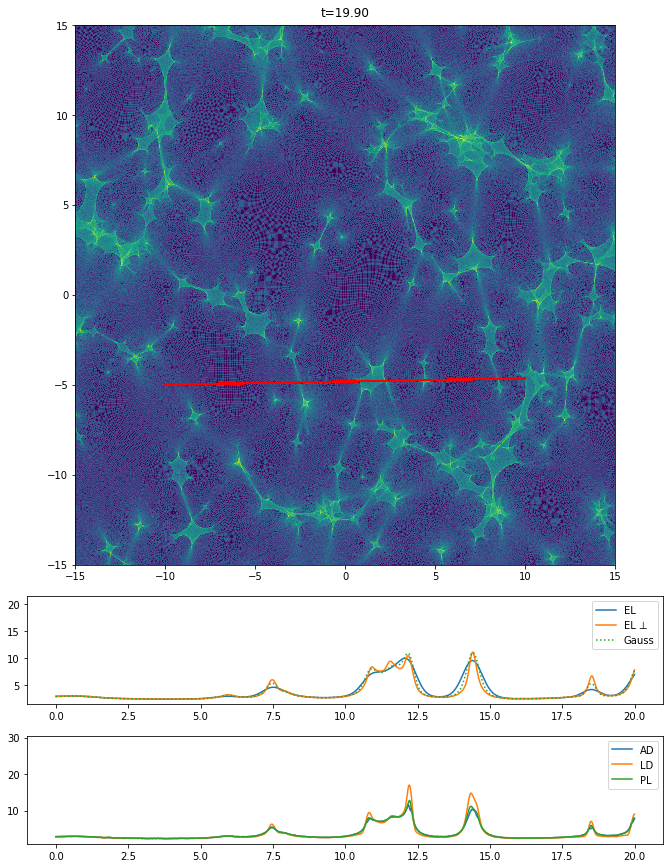

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), gridspec_kw={'height_ratios': [10, 2, 2]})
fig.tight_layout()
fig.subplots_adjust(left=0.09, top=0.98)

iterations = np.arange(0, 20, 0.1)
r = 0.2
e = 0.7
sigma = 0.5
moving_stars = True

ims = []
max_ampl = []
s_max = 0
for t in iterations:
    if 10 * t % 10 == 0:
        print("t=%.2f" % t)
    filename1 = f"output/s{sigma}_e0.1-0.9_r0.1-0.7{'_ms' if moving_stars else ''}/image_%.2f.dat" % t
    filename2 = f"output/s{sigma}_e0.1-0.9_r0.1-0.7{'_ms' if moving_stars else ''}/lc_%.2f.dat" % t
    img, extent = get_image_data(filename1, logscale=True)
    lc = get_lc_data(filename2)
    title = ax1.text(0.5, 1.01, "t=%.2f" % t, ha="center",va="bottom", transform=ax1.transAxes, fontsize="large")
    line1 = ax1.imshow(img, interpolation='none', extent=extent, origin='lower')
    ax1.plot(lc['y1'], lc['y2'], color='red')
    
    ad = lc[f'ad_r{r}']
    gs = lc[f'gs_r{r}']
    ld = lc[f'ld_r{r}']
    pl = lc[f'pl_r{r}']
    el = lc[f'el_r{r}_e{e}']
    el_orth = lc[f'el_orth_r{r}_e{e}']
    
    
    line2, = ax2.plot(lc['t'], el,      '-', color=colors[0], label='EL' if t == 0 else None)
    line3, = ax2.plot(lc['t'], el_orth, '-', color=colors[1], label='EL ⊥' if t == 0 else None)
    line4, = ax2.plot(lc['t'], gs,      '-', color=colors[2], linestyle='dotted', label='Gauss' if t == 0 else None)
    
    line5, = ax3.plot(lc['t'], ad,      '-', color=colors[0], label='AD' if t == 0 else None)
    line6, = ax3.plot(lc['t'], ld,      '-', color=colors[1], label='LD' if t == 0 else None)
    line7, = ax3.plot(lc['t'], pl,      '-', color=colors[2], label='PL' if t == 0 else None)
    
    _m = max([max(i) for i in [ad, gs, ld, pl, el, el_orth]])
    s_max = _m if _m > s_max else s_max
    
    ims.append([line1, line2, line3, line4, line5, line6, line7, title])

ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
#for l in ims:
#    _l1, _l3, _l6, _l7, _t = l
#    #_l1, _l2, _l3, _l4, _l5, _l6, _l7, _t = l
#    #_l2.axes.set_ylim([0, 1.05 * s_max])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat=False)
ani.save('images/dynamic_images_all.mp4')
plt.show()
plt.close()

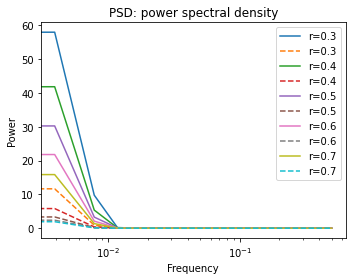

In [247]:
from scipy import signal
plt.figure(figsize=(5, 4))


x = get_lc_data('./output/s0.4_e0.1-0.9_r0.1-0.7/lc_0.00.dat')
for r in x.attrs['sources'][-5:]:
    #freqs, times, spectrogram = signal.spectrogram(sig)
    freqs1, psd1 = signal.welch(x[f'el_r{r}_e0.7'])
    freqs2, psd2 = signal.welch(x[f'el_r{r}_e0.9'])
    plt.semilogx(freqs1, psd1, label=f'r={r}')
    plt.semilogx(freqs2, psd2, label=f'r={r}', linestyle='dashed')
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend()
plt.tight_layout()

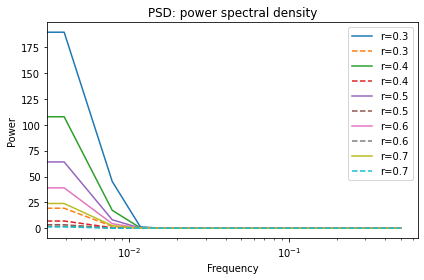

In [248]:
x = get_lc_data('./output/s0.4_e0.1-0.9_r0.1-0.7/lc_0.90.dat')
for r in x.attrs['sources'][-5:]:
    #freqs, times, spectrogram = signal.spectrogram(sig)
    freqs1, psd1 = signal.welch(x[f'el_r{r}_e0.7'])
    freqs2, psd2 = signal.welch(x[f'el_r{r}_e0.9'])
    plt.semilogx(freqs1, psd1, label=f'r={r}')
    plt.semilogx(freqs2, psd2, label=f'r={r}', linestyle='dashed')
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend()
plt.tight_layout()

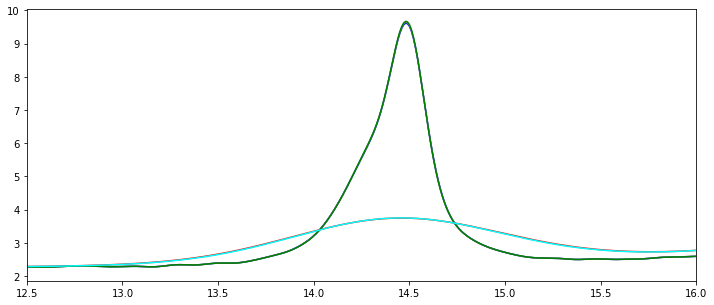

In [223]:
figure = plt.figure(figsize=(12,5))
plt.plot(x['t'], x['el_r0.1_e0.1'], color='blue')
#plt.plot(x['t'], x['el_r0.2_e0.5'], color='grey')
#plt.plot(x['t'], x['el_r0.3_e0.5'], color='grey')
plt.plot(x['t'], x['gs_r0.1'], color='grey')
#plt.plot(x['t'], x['el_r0.5_e0.5'], color='grey')
#plt.plot(x['t'], x['el_r0.6_e0.5'], color='grey')
plt.plot(x['t'], x['el_r0.7_e0.1'], color='red')


plt.plot(x['t'], x['el_orth_r0.1_e0.1'], color='green')
#plt.plot(x['t'], x['el_orth_r0.2_e0.5'], color='yellow')
#plt.plot(x['t'], x['el_orth_r0.3_e0.5'], color='yellow')
#plt.plot(x['t'], x['el_orth_r0.4_e0.5'], color='yellow')
#plt.plot(x['t'], x['el_orth_r0.5_e0.5'], color='yellow')
#plt.plot(x['t'], x['el_orth_r0.6_e0.5'], color='yellow')
plt.plot(x['t'], x['el_orth_r0.7_e0.1'], color='cyan')

plt.xlim([12.5, 16.0])
plt.show()

In [193]:
x.attrs

{'lcs_columns': 157,
 'lcs_t_steps': 2000,
 'lcs_sources': array([0.1  , 0.701, 0.1  ], dtype=float32),
 'lcs_eccentricities': array([0.1  , 0.901, 0.1  ], dtype=float32),
 'lcs': ['ad', 'gs', 'ld', 'pl'],
 'lcs_el': ['el', 'el_orth']}

In [207]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
 
# get the dataset
def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=3)
    return X, y

In [220]:
X, y = get_dataset()
X.shape, y.shape

((1000, 20), (1000,))

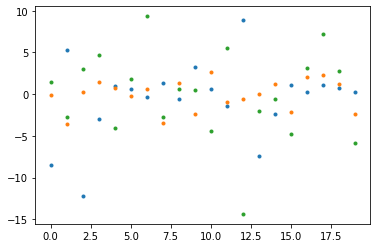

In [219]:
plt.plot(X[0], '.')
plt.plot(X[1], '.')
plt.plot(X[2], '.')

In [221]:
y

array([0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,